# 1. Project Credit Scoring Model

## 1.1 วัตถุประสงค์

**💛💚 วัตถุประสงค์ คือ สร้างโมเดลทำนายความเสี่ยงในการผิดนัดชำระหนี้ได้ โดยมี loan_status เป็นตัวแปรเป้าหมาย (target variable) ที่แสดงว่าผู้กู้จะผิดนัดชำระหนี้หรือไม่**
**โดยสถาบันการเงิน มี 2 เป้าหมายหลัก คือ**
1. ลดความเสี่ยง: ไม่อยากปล่อยกู้ให้กับ **ผู้ที่ผิดนัดชำระหนี้**
2. เพิ่มผลกำไร: อยากปล่อยกู้ให้กับ **ผู้ที่ไม่ผิดนัดชำระหนี้**  มากที่สุด

# 2. Importing Libraries

In [287]:
!pip  install missingno

In [288]:
!pip install -U imbalanced-learn

In [289]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as mso
import seaborn as sns
import os
import warnings 
warnings.filterwarnings("ignore")

In [290]:
import scipy

from scipy import stats
from scipy.stats import pearsonr
from scipy.stats import ttest_ind

In [291]:
from sklearn import metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

In [292]:
from imblearn.over_sampling import SMOTE

In [293]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# 3. Reading Dataset

In [294]:
df = pd.read_csv(r'C:\Users\muent\Desktop\my project for data analyst\Project-13_Loan_Prediction_Machine_Learning\Credit_Scoring_Dataset\credit_risk_dataset.csv')

In [295]:
df

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amount,loan_int_rate,loan_percent_income,historical_default,credit_history_length,loan_status
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,0.59,Y,3,1
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0.10,N,2,0
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,0.57,N,3,1
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,0.53,N,2,1
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,0.55,Y,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0.11,N,30,0
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0.15,N,19,0
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,0.46,N,28,1
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0.10,N,26,0


**💛 ตัวแปร 💛**

1. person_age :  อายุ                    
2. person_income : รายได้             
3. person_home_ownership : สถานะการเป็นเจ้าของบ้าน (Own: เป็นเจ้าของบ้าน, Mortgage: อยู่ระหว่างการผ่อนชำระสินเชื่อบ้าน, Rent: เช่าบ้านอยู่, Other: สถานะอื่นๆ ที่ไม่เข้าข่ายข้างต้น)        
4. person_emp_length : ระยะเวลาการทำงานของบุคคล              
5. loan_intent :  เจตนาการกู้ยืม                
6. loan_grade : เกรดเงินกู้                    
7. loan_amount : จำนวนเงินที่กู้ยืม                     
8. loan_int_rate : อัตราดอกเบี้ย                                  
9. loan_percent_income : สัดส่วนเงินกู้ต่อรายได้ , loan_percent_income = 30 หมายความว่าเงินกู้มีมูลค่าเท่ากับ 30% ของรายได้ประจำปีของผู้กู้        
10. historical_default : ประวัติการผิดนัดชำระหนี้ในอดีต      
11. credit_history_length : ระยะเวลาของประวัติเครดิต     
12. loan_status : สถานะการชำระหนี้  ,0 (non-default): หมายถึง ไม่ผิดนัดชำระหนี้, 1 (default): หมายถึง ผิดนัดชำระหนี้

In [296]:
df.dtypes

person_age                 int64
person_income              int64
person_home_ownership     object
person_emp_length        float64
loan_intent               object
loan_grade                object
loan_amount                int64
loan_int_rate            float64
loan_percent_income      float64
historical_default        object
credit_history_length      int64
loan_status                int64
dtype: object

In [297]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   person_age             32581 non-null  int64  
 1   person_income          32581 non-null  int64  
 2   person_home_ownership  32581 non-null  object 
 3   person_emp_length      31686 non-null  float64
 4   loan_intent            32581 non-null  object 
 5   loan_grade             32581 non-null  object 
 6   loan_amount            32581 non-null  int64  
 7   loan_int_rate          29465 non-null  float64
 8   loan_percent_income    32581 non-null  float64
 9   historical_default     32581 non-null  object 
 10  credit_history_length  32581 non-null  int64  
 11  loan_status            32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


# 4. Data Exploration 

## 4.1 Categorical Variable 

In [298]:
df

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amount,loan_int_rate,loan_percent_income,historical_default,credit_history_length,loan_status
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,0.59,Y,3,1
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0.10,N,2,0
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,0.57,N,3,1
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,0.53,N,2,1
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,0.55,Y,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0.11,N,30,0
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0.15,N,19,0
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,0.46,N,28,1
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0.10,N,26,0


### พิจารณาตัวแปรประเภทหมวดหมู่ (Categorical Variable)

### 4.1.1 person_home_ownership : สถานะการเป็นเจ้าของบ้าน

**person_home_ownership (สถานะการเป็นเจ้าของบ้าน)**
**คือ ตัวแปรหรือคอลัมน์ที่ใช้แสดงสถานะการเป็นเจ้าของบ้านของบุคคล โดยทั่วไปมักใช้ในฐานข้อมูลหรือการวิเคราะห์ข้อมูลที่เกี่ยวข้องกับสินเชื่อหรือการเงิน
ตัวแปรนี้อาจมีค่าต่างๆ เช่น :

* Own: เป็นเจ้าของบ้าน
* Mortgage: อยู่ระหว่างการผ่อนชำระสินเชื่อบ้าน
* Rent: เช่าบ้านอยู่
* Other: สถานะอื่นๆ ที่ไม่เข้าข่ายข้างต้น

In [299]:
df.person_home_ownership.value_counts(dropna= False)

RENT        16446
MORTGAGE    13444
OWN          2584
OTHER         107
Name: person_home_ownership, dtype: int64

In [300]:
countRENT = len(df[df.person_home_ownership == "RENT"])
countMORTGAGE = len(df[df.person_home_ownership == "MORTGAGE"])
countOWN = len(df[df.person_home_ownership == "OWN"])
countOTHER = len(df[df.person_home_ownership == "OTHER"])

print("Percantage of RENT : {:.2f}%".format( countRENT*100/len(df.person_home_ownership)))
print("Percantage of MORTGAGE : {:.2f}%".format( countMORTGAGE*100/len(df.person_home_ownership)))
print("Percantage of OWN : {:.2f}%".format( countOWN*100/len(df.person_home_ownership)))
print("Percantage of OTHER : {:.2f}%".format( countOTHER*100/len(df.person_home_ownership)))

Percantage of RENT : 50.48%
Percantage of MORTGAGE : 41.26%
Percantage of OWN : 7.93%
Percantage of OTHER : 0.33%


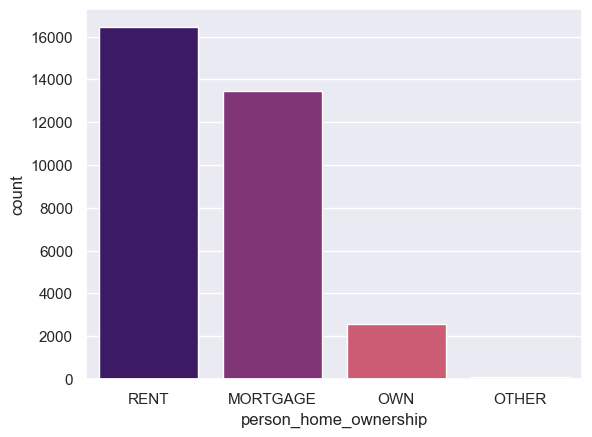

In [301]:
sns.countplot(data=df, x="person_home_ownership", palette="magma", 
              order=df["person_home_ownership"].value_counts().index)
plt.show()

### 4.1.2 loan_intent : เจตนาการกู้ยืม

**loan_intent (เจตนาการกู้ยืม)**
**คือ ตัวแปรที่ระบุวัตถุประสงค์หรือเหตุผลหลักในการขอสินเชื่อของผู้กู้ ซึ่งมักใช้ในการวิเคราะห์ความเสี่ยงและการตัดสินใจอนุมัติสินเชื่อ โดยแบ่งเป็นหมวดหมู่ต่างๆ :**

* Education: เพื่อการศึกษา
* Medical: เพื่อค่ารักษาพยาบาล
* Venture: เพื่อลงทุนในธุรกิจ
* Personal: เพื่อใช้จ่ายส่วนตัว
* Debt Consolidation: เพื่อรวมหนี้
* Home Improvement: เพื่อปรับปรุงที่อยู่อาศัย

In [302]:
df.loan_intent.value_counts(dropna= False) #dropna= False คือ นับค่า null ด้วย

EDUCATION            6453
MEDICAL              6071
VENTURE              5719
PERSONAL             5521
DEBTCONSOLIDATION    5212
HOMEIMPROVEMENT      3605
Name: loan_intent, dtype: int64

In [303]:
countEDUCATION = len(df[df.loan_intent == "EDUCATION"])
countMEDICAL = len(df[df.loan_intent == "MEDICAL"])
countVENTURE = len(df[df.loan_intent == "VENTURE"])
countPERSONAL = len(df[df.loan_intent == "PERSONAL"])
countDEBTCONSOLIDATION = len(df[df.loan_intent == "DEBTCONSOLIDATION"])
countHOMEIMPROVEMENT = len(df[df.loan_intent == "HOMEIMPROVEMENT"])

print("Percantage of EDUCATION : {:.2f}%".format(countEDUCATION*100/len(df.loan_intent)))
print("Percantage of MEDICAL : {:.2f}%".format(countMEDICAL*100/len(df.loan_intent)))
print("Percantage of VENTURE : {:.2f}%".format(countVENTURE*100/len(df.loan_intent)))
print("Percantage of PERSONAL : {:.2f}%".format(countPERSONAL*100/len(df.loan_intent)))
print("Percantage of DEBTCONSOLIDATION : {:.2f}%".format(countDEBTCONSOLIDATION*100/len(df.loan_intent)))
print("Percantage of HOMEIMPROVEMENT : {:.2f}%".format(countHOMEIMPROVEMENT*100/len(df.loan_intent)))

Percantage of EDUCATION : 19.81%
Percantage of MEDICAL : 18.63%
Percantage of VENTURE : 17.55%
Percantage of PERSONAL : 16.95%
Percantage of DEBTCONSOLIDATION : 16.00%
Percantage of HOMEIMPROVEMENT : 11.06%


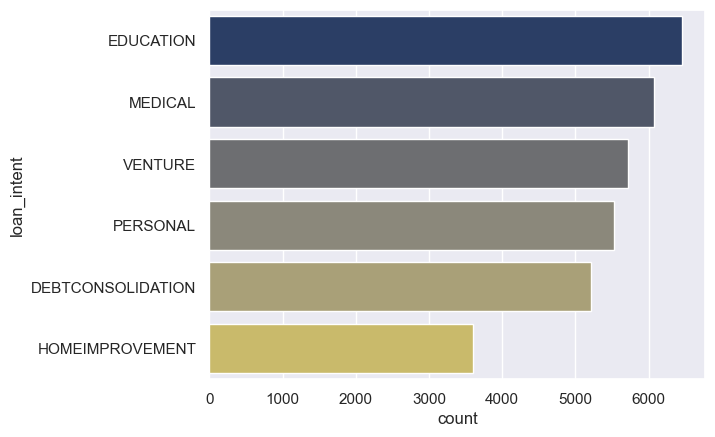

In [304]:
sns.countplot(data=df, y="loan_intent", palette="cividis", 
              order=df["loan_intent"].value_counts().index)
plt.show()

### 4.1.3 loan_grade : เกรดเงินกู้ 

**loan_grade ( เกรดเงินกู้) คือ การจัดอันดับหรือระดับคุณภาพของสินเชื่อ ซึ่งสถาบันการเงินใช้เพื่อประเมินความเสี่ยงและกำหนดเงื่อนไขของสินเชื่อ โดยทั่วไปมักแบ่งเป็นระดับต่างๆ ดังนี้:**

* A: คุณภาพสูงสุด, ความเสี่ยงต่ำสุด
* B: คุณภาพดี, ความเสี่ยงต่ำ
* C: คุณภาพปานกลาง, ความเสี่ยงปานกลาง
* D: คุณภาพต่ำกว่าปานกลาง, ความเสี่ยงสูงกว่าปานกลาง
* E: คุณภาพต่ำ, ความเสี่ยงสูง
* F: คุณภาพต่ำมาก, ความเสี่ยงสูงมาก
* G: คุณภาพต่ำที่สุด, ความเสี่ยงสูงที่สุด

In [305]:
df.loan_grade.value_counts(dropna= False)

A    10777
B    10451
C     6458
D     3626
E      964
F      241
G       64
Name: loan_grade, dtype: int64

In [306]:
count_grade_A = len(df[df.loan_grade == "A"])
count_grade_B = len(df[df.loan_grade == "B"])
count_grade_C = len(df[df.loan_grade == "C"])
count_grade_D = len(df[df.loan_grade == "D"])
count_grade_E = len(df[df.loan_grade == "E"])
count_grade_F = len(df[df.loan_grade == "F"])
count_grade_G = len(df[df.loan_grade == "G"])
                      
print("Percantage of loan grade A : {:.2f}%".format(count_grade_A*100/len(df.loan_grade)))
print("Percantage of loan grade B : {:.2f}%".format(count_grade_B*100/len(df.loan_grade)))
print("Percantage of loan grade C : {:.2f}%".format(count_grade_C*100/len(df.loan_grade)))
print("Percantage of loan grade D : {:.2f}%".format(count_grade_D*100/len(df.loan_grade)))
print("Percantage of loan grade E : {:.2f}%".format(count_grade_E*100/len(df.loan_grade)))
print("Percantage of loan grade F : {:.2f}%".format(count_grade_F*100/len(df.loan_grade)))
print("Percantage of loan grade G : {:.2f}%".format(count_grade_G*100/len(df.loan_grade)))

Percantage of loan grade A : 33.08%
Percantage of loan grade B : 32.08%
Percantage of loan grade C : 19.82%
Percantage of loan grade D : 11.13%
Percantage of loan grade E : 2.96%
Percantage of loan grade F : 0.74%
Percantage of loan grade G : 0.20%


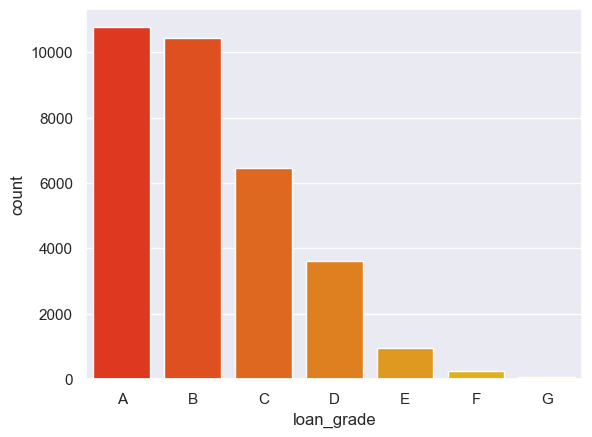

In [307]:
sns.countplot(data=df, x="loan_grade", palette="autumn", 
              order=df["loan_grade"].value_counts().index)
plt.show()

### 4.1.4 historical_default : ประวัติการผิดนัดชำระหนี้ในอดีต

**historical_default (ประวัติการผิดนัดชำระหนี้ในอดีต)  เป็นตัวแปรที่ใช้ในการประเมินความเสี่ยงทางการเงินของผู้กู้ โดยทั่วไปมักมีค่าเป็น:**

* Yes (1): ผู้กู้**เคย**มีประวัติผิดนัดชำระหนี้ในอดีต
* No (0): ผู้กู้**ไม่เคย**มีประวัติผิดนัดชำระหนี้ในอดีต

In [308]:
df.historical_default.value_counts(dropna = False)

N    26836
Y     5745
Name: historical_default, dtype: int64

In [309]:
count_historical_default_No = len(df[df.historical_default == "N"])
count_historical_default_Yes = len(df[df.historical_default == "Y"])

print("Percantage of historical default is No : {:.2f}%".format(count_historical_default_No*100/len(df.historical_default)))
print("Percantage of historical default is Yes : {:.2f}%".format(count_historical_default_Yes*100/len(df.historical_default)))

Percantage of historical default is No : 82.37%
Percantage of historical default is Yes : 17.63%


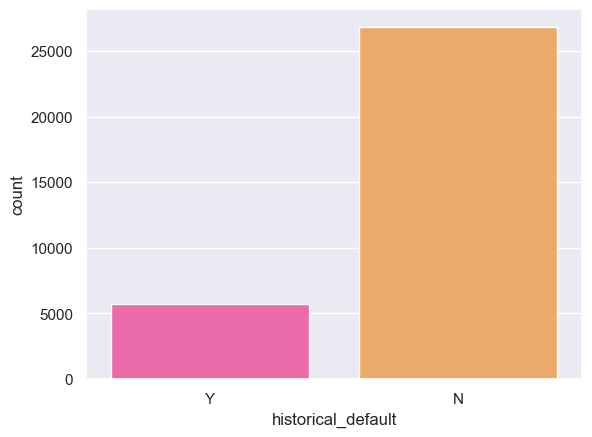

In [310]:
sns.countplot(data = df , x = "historical_default", palette= "spring")
plt.show()

## 4.2 Numerical Variable

In [311]:
df.select_dtypes(exclude='object').nunique()

person_age                 58
person_income            4295
person_emp_length          36
loan_amount               753
loan_int_rate             348
loan_percent_income        77
credit_history_length      29
loan_status                 2
dtype: int64

### 4.2.1 ค่าสถิติเบื้องต้น

In [312]:
df.select_dtypes(exclude='object').describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,32581.0,27.734600,6.348078,20.00,23.00,26.00,30.00,144.00
person_income,32581.0,66074.848470,61983.119168,4000.00,38500.00,55000.00,79200.00,6000000.00
person_emp_length,31686.0,4.789686,4.142630,0.00,2.00,4.00,7.00,123.00
loan_amount,32581.0,9589.371106,6322.086646,500.00,5000.00,8000.00,12200.00,35000.00
loan_int_rate,29465.0,11.011695,3.240459,5.42,7.90,10.99,13.47,23.22
loan_percent_income,32581.0,0.170203,0.106782,0.00,0.09,0.15,0.23,0.83
credit_history_length,32581.0,5.804211,4.055001,2.00,3.00,4.00,8.00,30.00
loan_status,32581.0,0.218164,0.413006,0.00,0.00,0.00,0.00,1.00


### 4.2.2 Correlation (ความสัมพันธ์ของตัวแปร)

In [313]:
df.corr()

,person_age,person_income,person_emp_length,loan_amount,loan_int_rate,loan_percent_income,credit_history_length,loan_status
person_age,1.000000,0.173202,0.163106,0.050787,0.012580,-0.042411,0.859133,-0.021629
person_income,0.173202,1.000000,0.134268,0.266820,0.000792,-0.254471,0.117987,-0.144449
person_emp_length,0.163106,0.134268,1.000000,0.113082,-0.056405,-0.054111,0.144699,-0.082489
loan_amount,0.050787,0.266820,0.113082,1.000000,0.146813,0.572612,0.041967,0.105376
loan_int_rate,0.012580,0.000792,-0.056405,0.146813,1.000000,0.120314,0.016696,0.335133
loan_percent_income,-0.042411,-0.254471,-0.054111,0.572612,0.120314,1.000000,-0.031690,0.379366
credit_history_length,0.859133,0.117987,0.144699,0.041967,0.016696,-0.031690,1.000000,-0.015529
loan_status,-0.021629,-0.144449,-0.082489,0.105376,0.335133,0.379366,-0.015529,1.000000


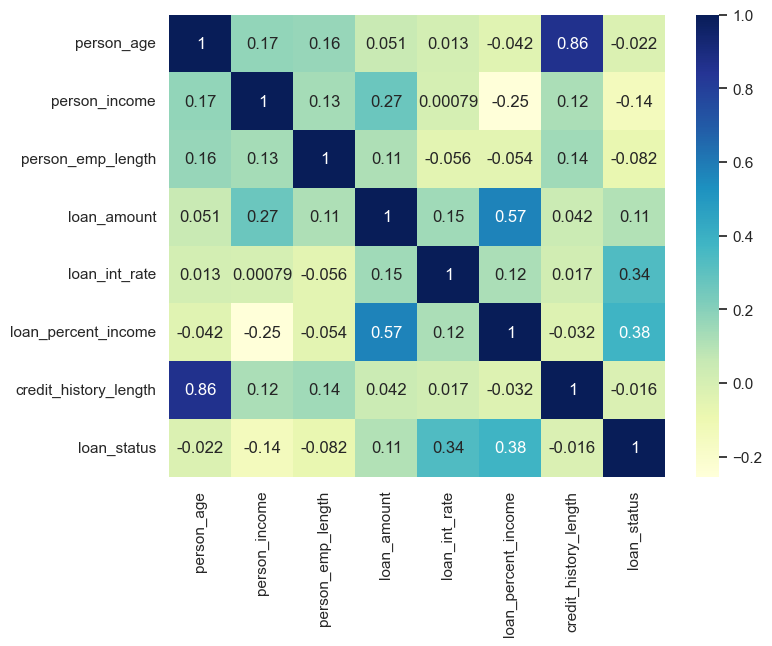

In [314]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot= True, cmap='YlGnBu');

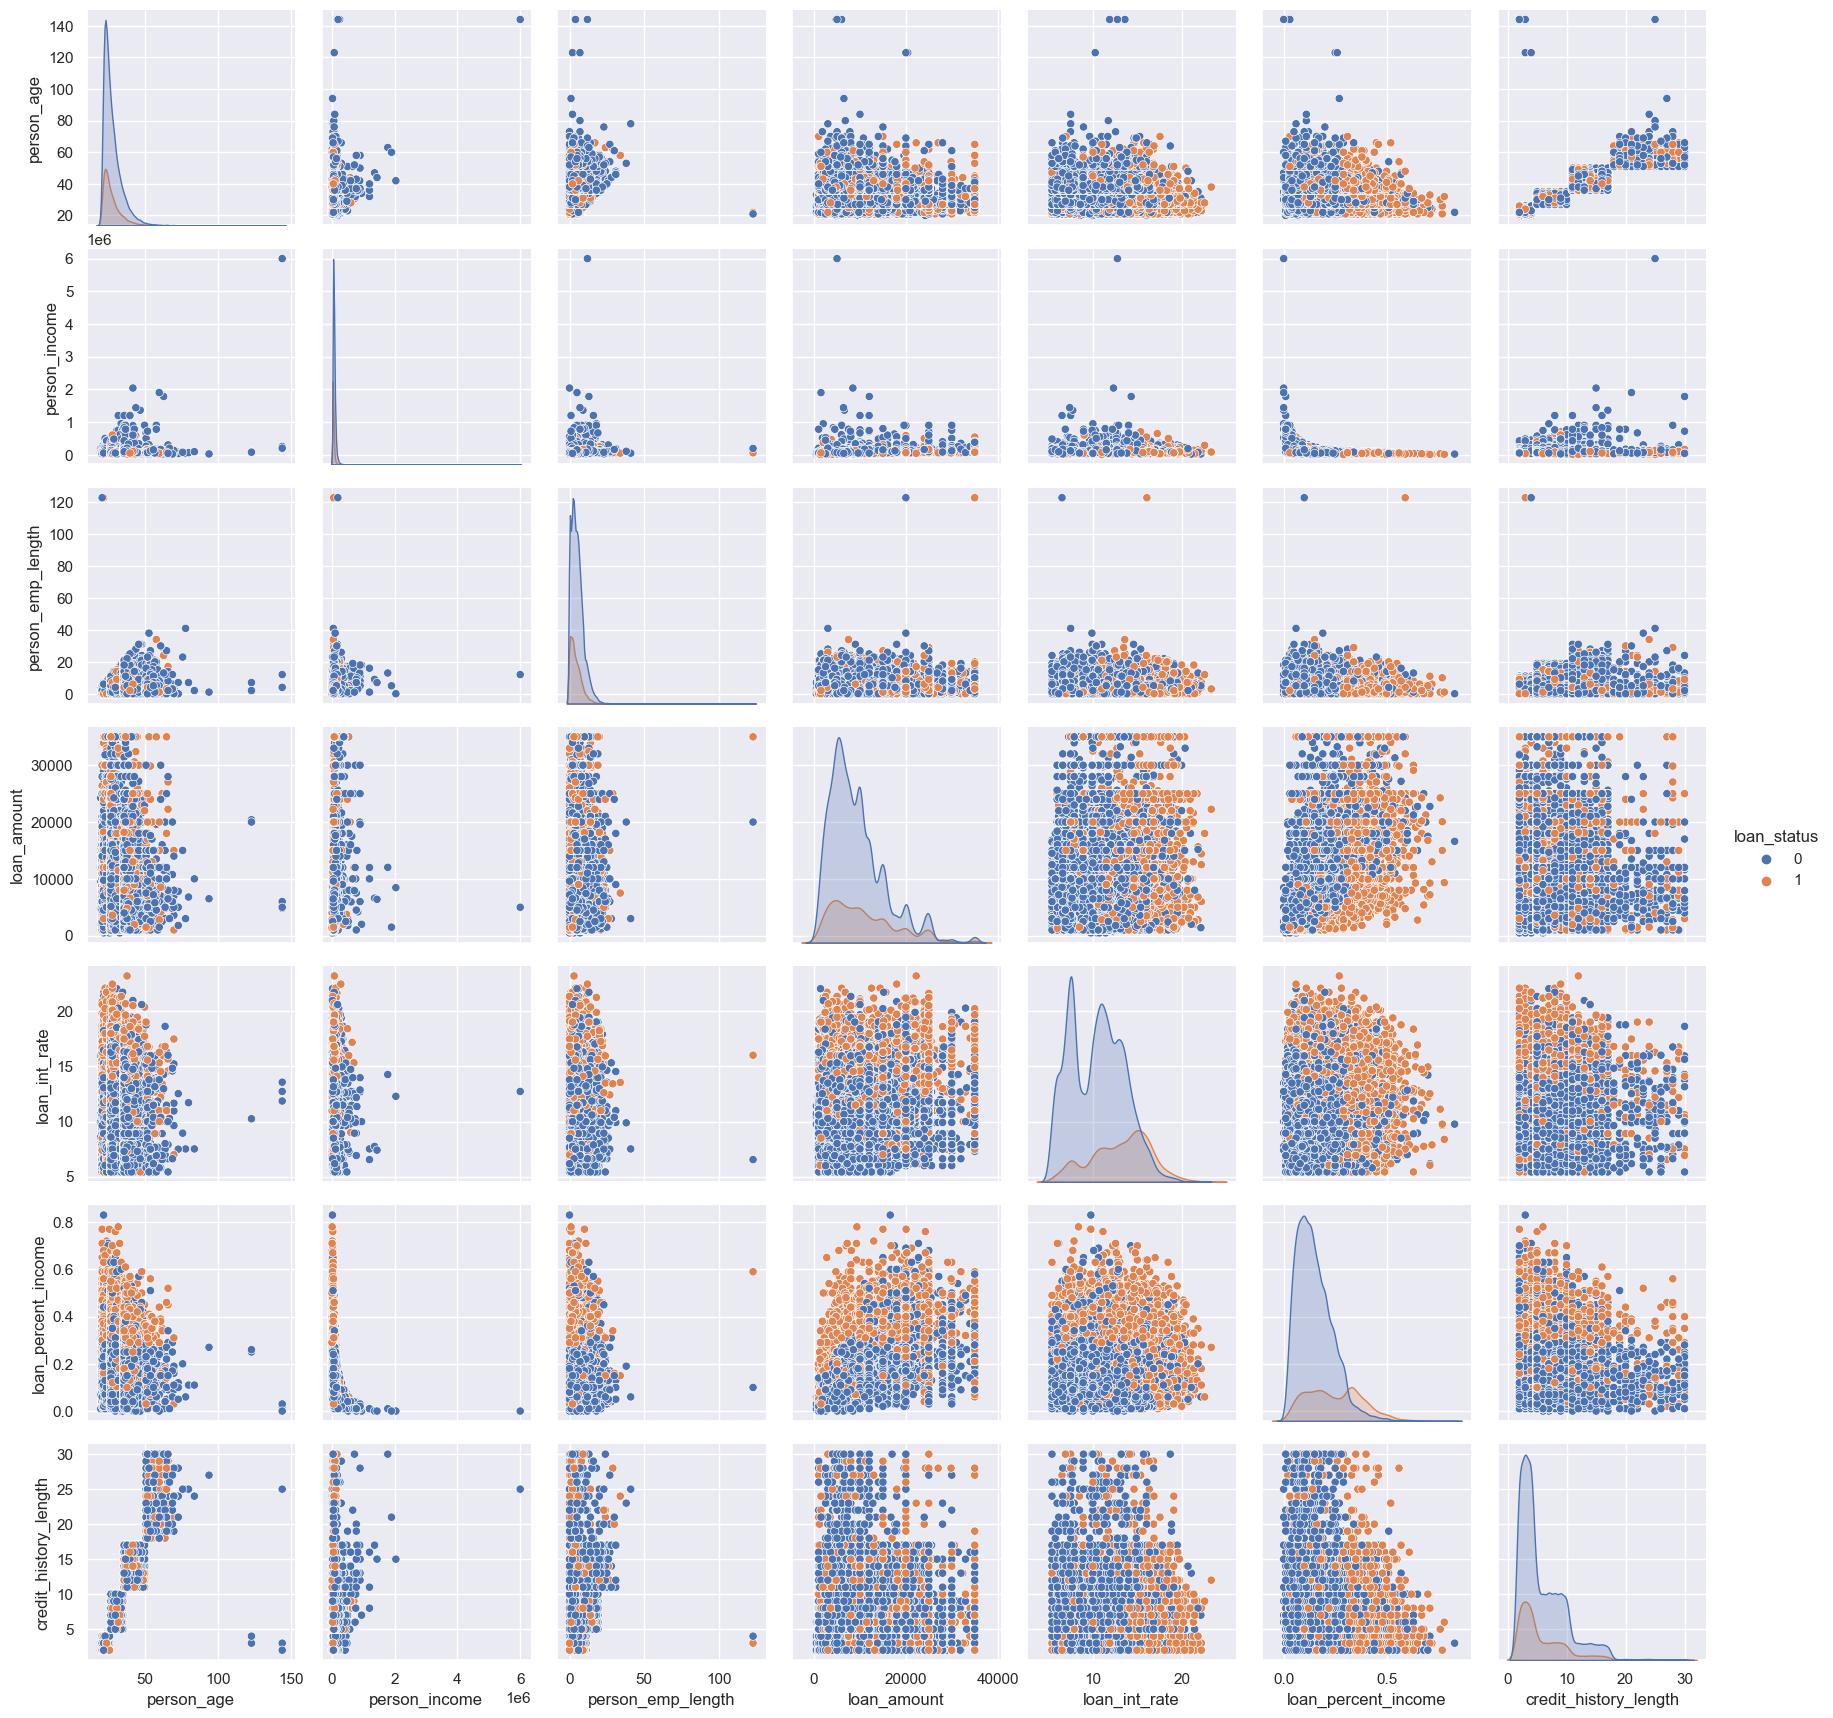

In [315]:
sns.pairplot(df.select_dtypes(exclude='object'), hue = 'loan_status');

✅ กราฟความสัมพันธ์ของตัวแปรเป็นแบบ Non-linear

### 4.2.3 การกระจายตัว : จะพล็อตกราฟ Histogram และ Box plot เพื่อพิจารณาการกระจายตัวและ ดู outlier

#### 4.2.3.1 Histogram Distribution 

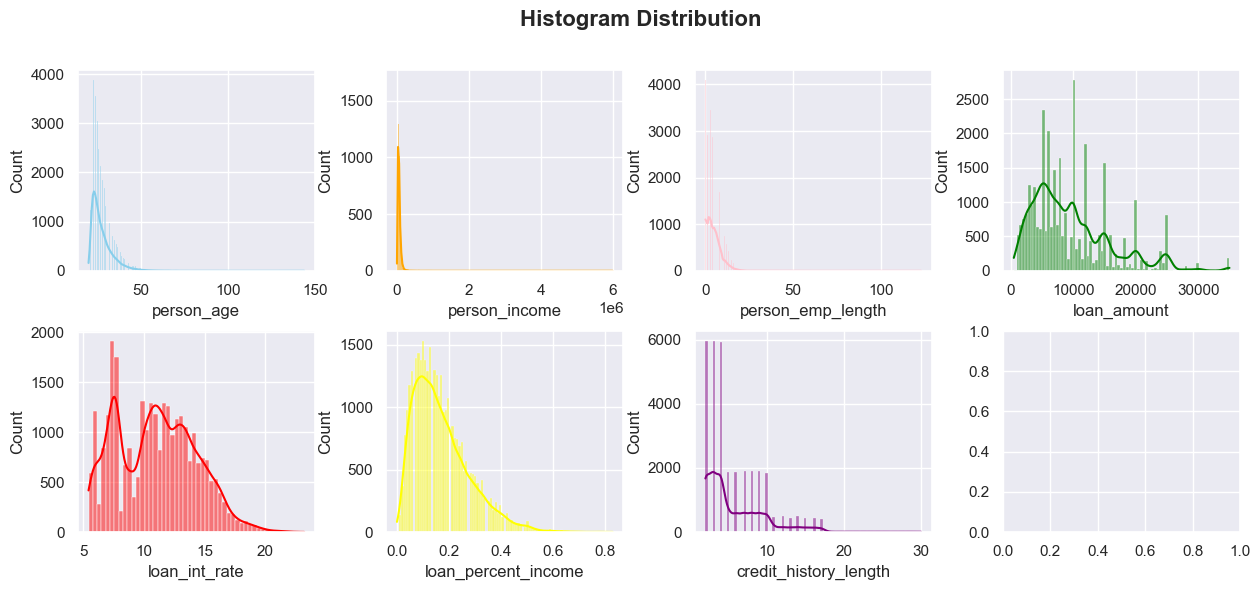

In [316]:
sns.set(style="darkgrid")
fig, axs = plt.subplots(2, 4, figsize=(15, 6), sharex= False)

sns.histplot(data=df, x="person_age", kde=True, ax=axs[0, 0], color='skyblue')
sns.histplot(data=df, x="person_income", kde=True, ax=axs[0, 1], color='orange')
sns.histplot(data=df, x="person_emp_length", kde=True, ax=axs[0, 2], color='pink')
sns.histplot(data=df, x="loan_amount", kde=True, ax=axs[0, 3], color='green')
sns.histplot(data=df, x="loan_int_rate", kde=True, ax=axs[1, 0], color='red')
sns.histplot(data=df, x="loan_percent_income", kde=True, ax=axs[1, 1], color='yellow')
sns.histplot(data=df, x="credit_history_length", kde=True, ax=axs[1, 2], color='purple')

fig.suptitle("Histogram Distribution", fontsize=16, fontweight='bold')
fig.subplots_adjust(hspace= 0.3 ,wspace=0.3)

#### 4.2.3.2  Boxplot

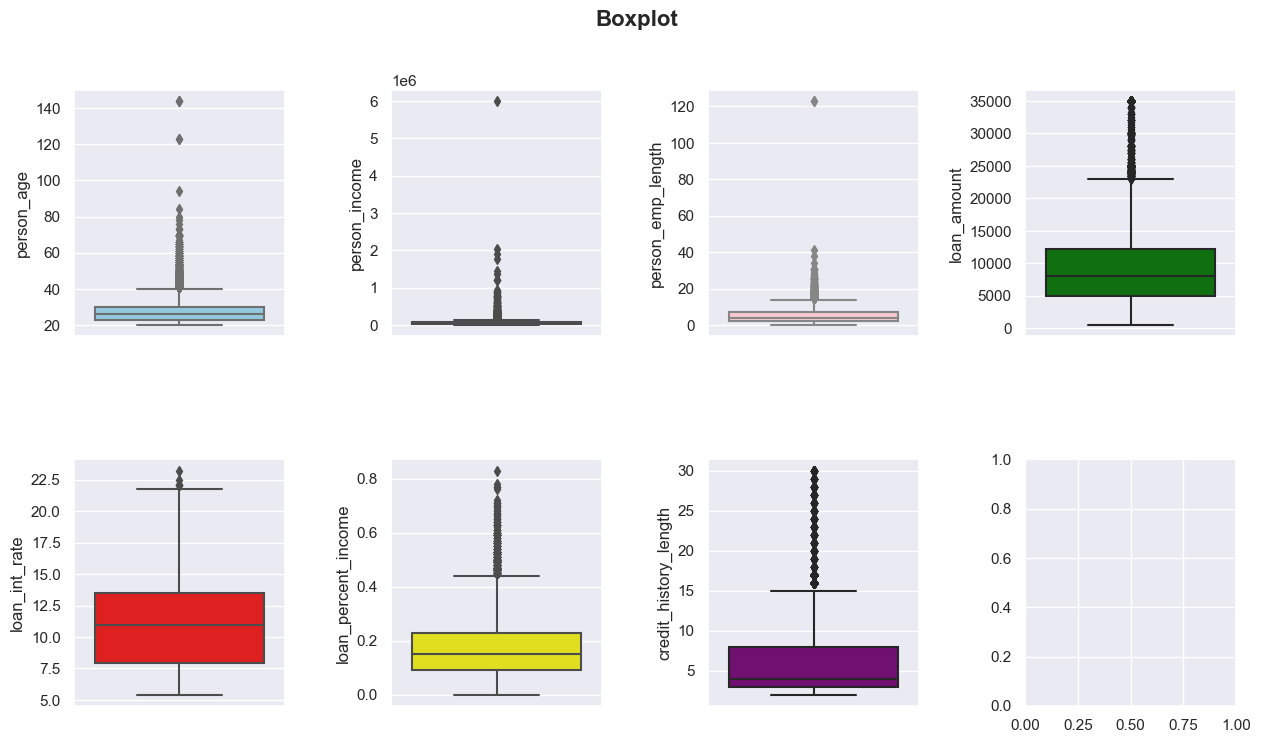

In [317]:
sns.set(style="darkgrid")
fig, axs1 = plt.subplots(2, 4, figsize=(15, 8), sharex= False)

sns.boxplot(data=df, y="person_age", ax=axs1[0, 0], color='skyblue')
sns.boxplot(data=df, y="person_income", ax=axs1[0, 1], color='orange')
sns.boxplot(data=df, y="person_emp_length", ax=axs1[0, 2], color='pink')
sns.boxplot(data=df, y="loan_amount", ax=axs1[0, 3], color='green')
sns.boxplot(data=df, y="loan_int_rate", ax=axs1[1, 0], color='red')
sns.boxplot(data=df, y="loan_percent_income", ax=axs1[1, 1], color='yellow')
sns.boxplot(data=df, y="credit_history_length", ax=axs1[1, 2], color='purple')

fig.suptitle("Boxplot", fontsize=16, fontweight='bold')
fig.subplots_adjust(hspace= 0.5, wspace= 0.5)

## 4.3 Bivariate analysis: วิเคราะห์ความสัมพันธ์ของแต่ละตัวแปร

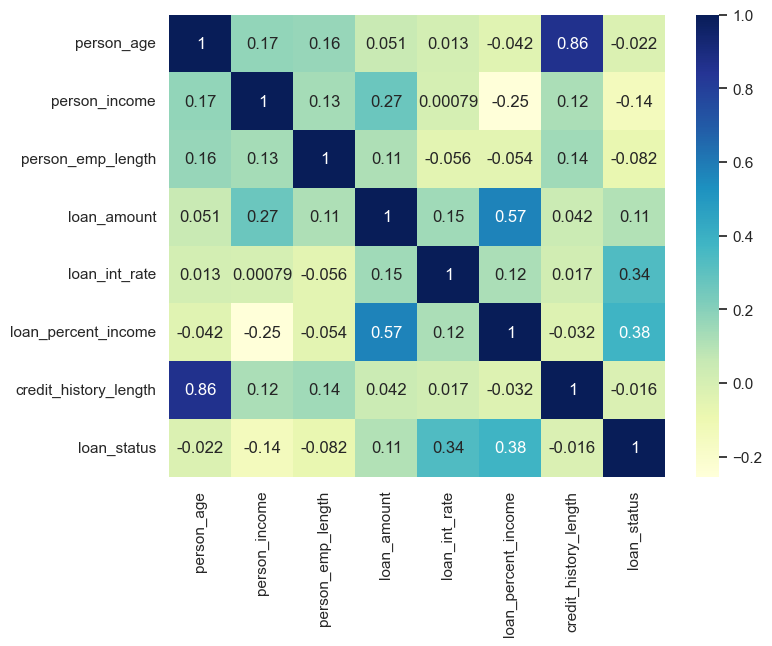

In [318]:
plt.figure(figsize=(8,6))
sns.heatmap(df.corr(), annot= True, cmap='YlGnBu');

### 4.3.1 Person age(อายุ) & Credit history length(ระยะเวลาของประวัติเครดิต)

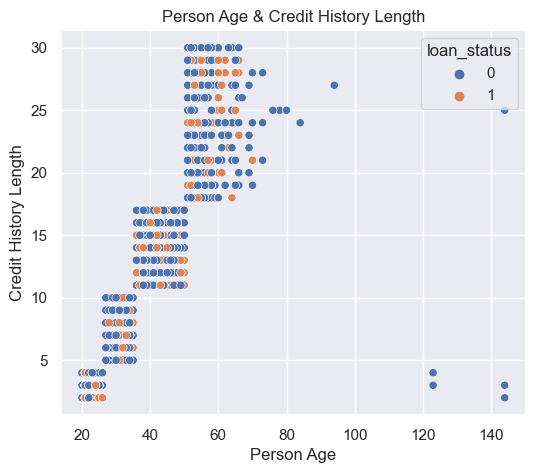

In [319]:
plt.figure(figsize=(6, 5))
sns.scatterplot(data=df, x="person_age", y="credit_history_length", hue = "loan_status" )
plt.xlabel("Person Age")
plt.ylabel("Credit History Length")
plt.title("Person Age & Credit History Length")
plt.show()

 **กราฟนี้แสดงความสัมพันธ์ระหว่างอายุของบุคคล(person_age) และ ระยะเวลาประวัติเครดิต(credit_history_length) 
 โดยแบ่งสีตามสถานะการชำระหนี้ (loan_status)**

* ไม่มีแนวโน้มที่ชัดเจน  ข้อมูลกระจายตัวค่อนข้างสุ่ม ไม่เห็นแนวโน้มเชิงเส้นหรือไม่เป็นเชิงเส้นที่ชัดเจนระหว่างอายุและประวัติเครดิต
* อายุเพิ่มขึ้น ระยะเวลาประวัติเครดิตก็เพิ่มขึ้น ซึ่งก็เป็นสิ่งที่ปกติอยู่แล้ว
* ยากที่จะสรุปว่าอายุและประวัติเครดิตมีผลต่อการผิดนัดชำระหนี้อย่างไร

### 4.3.2 Loan amount (จำนวนเงินกู้) & Loan percent income (สัดส่วนเงินกู้ต่อรายได้)

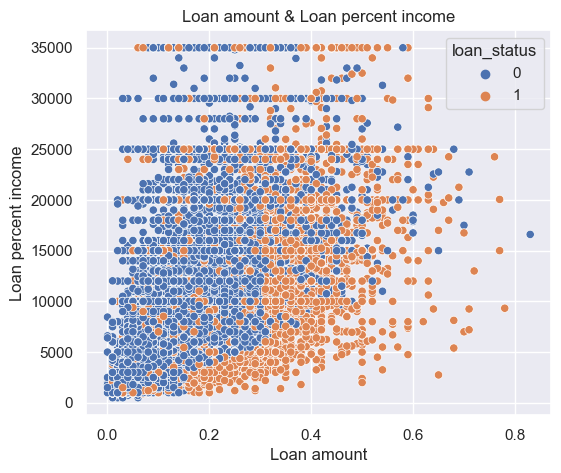

In [320]:
plt.figure(figsize=(6, 5))
sns.scatterplot(data=df, x="loan_percent_income", y="loan_amount",  hue = "loan_status")
plt.xlabel("Loan amount")
plt.ylabel("Loan percent income")
plt.title("Loan amount & Loan percent income")
plt.show()

**กราฟนี้แสดงความสัมพันธ์ระหว่างจำนวนเงินกู้ (loan_amount) และ สัดส่วนเงินกู้ต่อรายได้ (loan_amount ) โดยแบ่งสีตามสถานะการชำระหนี้ (loan_status)**

* ไม่มีแนวโน้มที่ชัดเจน ข้อมูลกระจายตัวค่อนข้างสุ่ม 
* ไม่เห็นแนวโน้มเชิงเส้นหรือไม่เป็นเชิงเส้นที่ชัดเจน(non-linear)
*  ข้อมูลของผู้ที่ผิดนัดและไม่ผิดนัดทับซ้อนกัน ยังไม่สามารถสรุปได้ว่าจำนวนเงินกู้และสัดส่วนเงินกู้ต่อรายได้มีผลต่อการผิดนัดชำระหนี้อย่างไร

### 4.3.3 Loan status (สถานะการชำระหนี้)  & Loan percent income (สัดส่วนเงินกู้ต่อรายได้)

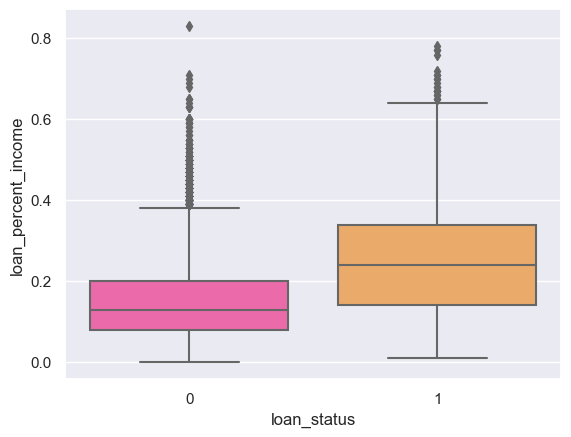

In [321]:
sns.boxplot(x="loan_status", y="loan_percent_income", data=df, palette="spring")
plt.show()

**กราฟนี้แสดงการกระจายของสัดส่วนเงินกู้ต่อรายได้(Loan percent income) แยกตามสถานะการชำระหนี้ (loan_status)**

* มี outliers (ค่าผิดปกติ) ทั้งในกลุ่มผู้ที่ผิดนัดชำระหนี้ (1) และไม่ผิดนัด (0) 
* มีการกระจายตัวเบ้ขวา 
* Median ของ loan_percent_income ของผู้ที่ผิดนัดชำระหนี้ (1) สูงกว่า ไม่ผิดนัดชำระหนี้ (0) 
* สัดส่วนเงินกู้ต่อรายได้(loan_percent_income)อาจจะไม่ได้เป็นปัจจัยหลักที่ส่งผลต่อการผิดนัดชำระหนี้(loan_status = 1)

### 4.3.4 Loan status (สถานะการชำระหนี้)   & Loan int rate (อัตราดอกเบี้ยเงินกู้ )

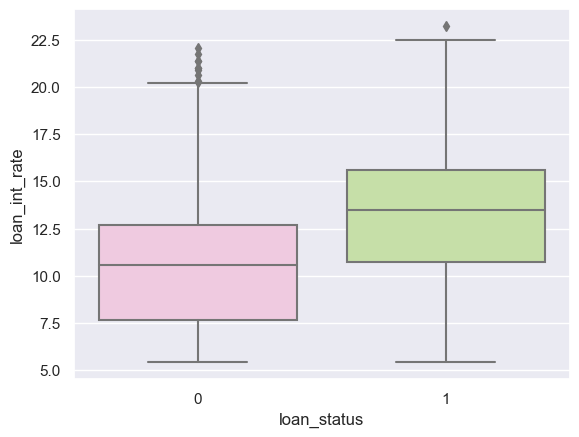

In [322]:
sns.boxplot(x="loan_status", y="loan_int_rate", data=df, palette="PiYG")
plt.show()

**กราฟนี้แสดงการกระจายของอัตราดอกเบี้ยสินเชื่อ(loan_int_rate) แยกตามสถานะการชำระหนี้(loan_status)**

* มี outliers  ทั้งในกลุ่มผู้ที่ผิดนัดชำระหนี้ (1) และไม่ผิดนัด (0) 
* มีการกระจายตัวเบ้ขวา 
* Median ของ loan_int_rate ของผู้ที่ผิดนัดชำระหนี้ (1) สูงกว่าผู้ไม่ผิดนัด (0) หมายความว่า  อัตราดอกเบี้ยเงินกู้ในกลุ่มผู้ที่ผิดนัดชำระหนี้ (1) จะสูงกว่า

# 4.4 Null Values 

In [323]:
df.isnull().sum()

person_age                  0
person_income               0
person_home_ownership       0
person_emp_length         895
loan_intent                 0
loan_grade                  0
loan_amount                 0
loan_int_rate            3116
loan_percent_income         0
historical_default          0
credit_history_length       0
loan_status                 0
dtype: int64

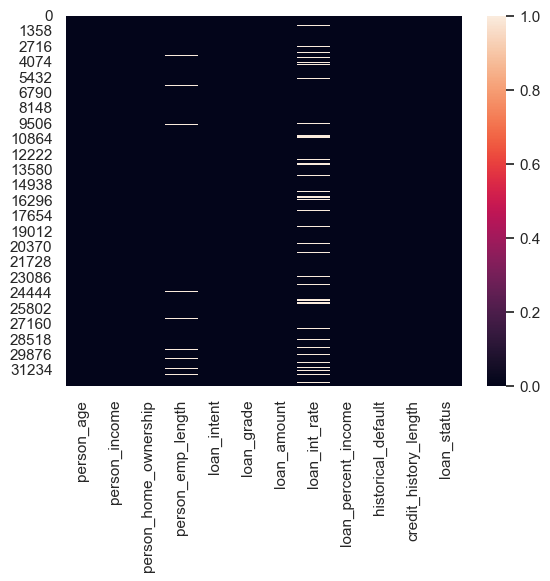

In [324]:
sns.heatmap(df.isnull());

# 5. Data Preprocessing 

## 5.1 Data Imputation การประมาณค่า

    💛 การประมาณค่า (Imputation) เป็นเทคนิคในการแทนที่ค่าที่หายไปในชุดข้อมูลด้วยค่าประมาณการ 
    💛 ในส่วนนี้จะทำการประมาณค่าสำหรับตัวแปรที่มีค่าหายไป(Missing Values)

   ### 5.1.1 Categorical Variables : ในส่วนของตัวแปรชนิด categorical variables จะแทนค่าที่หายไปด้วย ค่า **"mode"**

In [325]:
df.select_dtypes(include=['object']).isnull().sum()

person_home_ownership    0
loan_intent              0
loan_grade               0
historical_default       0
dtype: int64

❌ Categorical variables ไม่มีค่า Missing Values

### 5.1.2 Numerical Variables : ในส่วนของตัวแปรชนิด Numerical Variables จะแทนค่าที่หายไปด้วย ค่า mean และ mode

In [326]:
df.select_dtypes(include=['int64', 'float64']).isnull().sum()

person_age                  0
person_income               0
person_emp_length         895
loan_amount                 0
loan_int_rate            3116
loan_percent_income         0
credit_history_length       0
loan_status                 0
dtype: int64

In [327]:
df["person_emp_length"].fillna(df["person_emp_length"].mode()[0], inplace = True)
df["loan_int_rate"].fillna(df["loan_int_rate"].mean(), inplace = True)

In [328]:
df.isnull().sum()

person_age               0
person_income            0
person_home_ownership    0
person_emp_length        0
loan_intent              0
loan_grade               0
loan_amount              0
loan_int_rate            0
loan_percent_income      0
historical_default       0
credit_history_length    0
loan_status              0
dtype: int64

## 5.2 One-hot Encoding  การทำรหัส encoding สำหรับข้อมูล categorical variables

In [329]:
df = pd.get_dummies(df)

In [330]:
df.head()

,person_age,person_income,person_emp_length,loan_amount,loan_int_rate,loan_percent_income,credit_history_length,loan_status,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,historical_default_N,historical_default_Y
0,22,59000,123.0,35000,16.02,0.59,3,1,0,0,...,0,0,0,0,1,0,0,0,0,1
1,21,9600,5.0,1000,11.14,0.10,2,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,25,9600,1.0,5500,12.87,0.57,3,1,1,0,...,0,0,0,1,0,0,0,0,1,0
3,23,65500,4.0,35000,15.23,0.53,2,1,0,0,...,0,0,0,1,0,0,0,0,1,0
4,24,54400,8.0,35000,14.27,0.55,4,1,0,0,...,0,0,0,1,0,0,0,0,0,1


In [331]:
# Drop columns 
df = df.drop( 'historical_default_N', axis = 1)

# Rename columns name
new = {'historical_default_Y': 'historical_default'}
       
df.rename(columns=new, inplace=True)

In [332]:
df

,person_age,person_income,person_emp_length,loan_amount,loan_int_rate,loan_percent_income,credit_history_length,loan_status,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,...,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,historical_default
0,22,59000,123.0,35000,16.02,0.59,3,1,0,0,...,1,0,0,0,0,1,0,0,0,1
1,21,9600,5.0,1000,11.14,0.10,2,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,25,9600,1.0,5500,12.87,0.57,3,1,1,0,...,0,0,0,0,1,0,0,0,0,0
3,23,65500,4.0,35000,15.23,0.53,2,1,0,0,...,0,0,0,0,1,0,0,0,0,0
4,24,54400,8.0,35000,14.27,0.55,4,1,0,0,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,1.0,5800,13.16,0.11,30,0,1,0,...,1,0,0,0,1,0,0,0,0,0
32577,54,120000,4.0,17625,7.49,0.15,19,0,1,0,...,1,0,1,0,0,0,0,0,0,0
32578,65,76000,3.0,35000,10.99,0.46,28,1,0,0,...,0,0,0,1,0,0,0,0,0,0
32579,56,150000,5.0,15000,11.48,0.10,26,0,1,0,...,1,0,0,1,0,0,0,0,0,0


## 5.3 Remove Outliers : จัดการค่า Outlier

    💛 ใช้วิธี Interquartile Range (IQR) : คำนวณ IQR (Q3-Q1) และกำหนดขอบเขต (Q1-1.5IQR) และ (Q3+1.5IQR)
    💛 ใช้ Clip: เพราะต้องการรักษาจำนวนข้อมูลไว้ แต่ลดผลกระทบของ Outliers

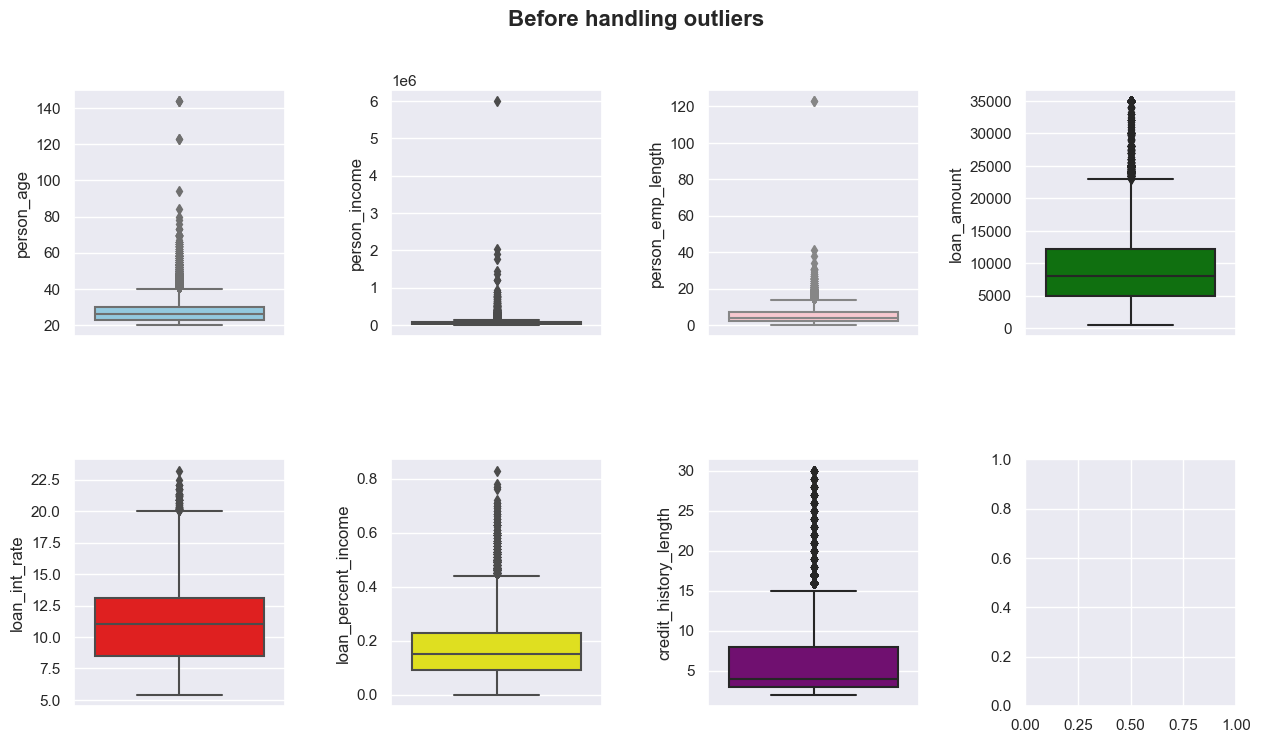

In [333]:
sns.set(style="darkgrid")
fig, axs1 = plt.subplots(2, 4, figsize=(15, 8), sharex= False)

sns.boxplot(data=df, y="person_age", ax=axs1[0, 0], color='skyblue')
sns.boxplot(data=df, y="person_income", ax=axs1[0, 1], color='orange')
sns.boxplot(data=df, y="person_emp_length", ax=axs1[0, 2], color='pink')
sns.boxplot(data=df, y="loan_amount", ax=axs1[0, 3], color='green')
sns.boxplot(data=df, y="loan_int_rate", ax=axs1[1, 0], color='red')
sns.boxplot(data=df, y="loan_percent_income", ax=axs1[1, 1], color='yellow')
sns.boxplot(data=df, y="credit_history_length", ax=axs1[1, 2], color='purple')

fig.suptitle("Before handling outliers", fontsize=16, fontweight='bold')
fig.subplots_adjust(hspace= 0.5, wspace= 0.5)

In [334]:
# คอลัมน์ที่ต้องการจัดการ outliers
columns= ['person_age', 'person_income', 'person_emp_length', 
                     'loan_amount', 'loan_int_rate', 'loan_percent_income', 'credit_history_length']

# จัดการ outliers ใน columns ที่ระบุโดยใช้ IQR
for col in columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = np.clip(df[col], lower_bound, upper_bound) 
    
    #np.clip() จาก NumPy เพื่อจำกัดค่าในคอลัมน์ให้อยู่ในช่วงที่กำหนด 
    #วิธีการทำงานของ np.clip():

       # ค่าที่ต่ำกว่า lower_bound จะถูกแทนที่ด้วย lower_bound
       # ค่าที่สูงกว่า upper_bound จะถูกแทนที่ด้วย upper_bound
       # ค่าที่อยู่ระหว่าง lower_bound และ upper_bound จะคงเดิม

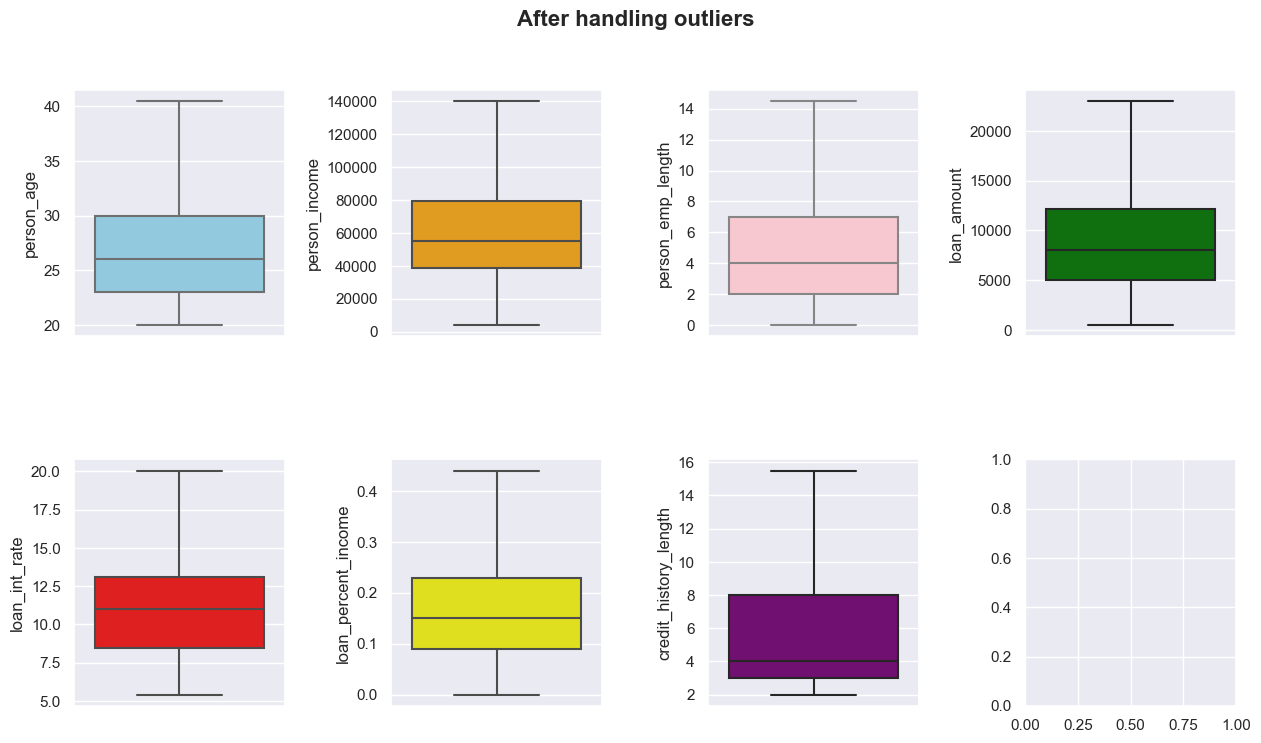

In [335]:
sns.set(style="darkgrid")
fig, axs1 = plt.subplots(2, 4, figsize=(15, 8), sharex= False)

sns.boxplot(data=df, y="person_age", ax=axs1[0, 0], color='skyblue')
sns.boxplot(data=df, y="person_income", ax=axs1[0, 1], color='orange')
sns.boxplot(data=df, y="person_emp_length", ax=axs1[0, 2], color='pink')
sns.boxplot(data=df, y="loan_amount", ax=axs1[0, 3], color='green')
sns.boxplot(data=df, y="loan_int_rate", ax=axs1[1, 0], color='red')
sns.boxplot(data=df, y="loan_percent_income", ax=axs1[1, 1], color='yellow')
sns.boxplot(data=df, y="credit_history_length", ax=axs1[1, 2], color='purple')

fig.suptitle("After handling outliers", fontsize=16, fontweight='bold')
fig.subplots_adjust(hspace= 0.5, wspace= 0.5)

In [336]:
df

,person_age,person_income,person_emp_length,loan_amount,loan_int_rate,loan_percent_income,credit_history_length,loan_status,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,...,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,historical_default
0,22.0,59000,14.5,23000,16.02,0.44,3.0,1,0,0,...,1,0,0,0,0,1,0,0,0,1
1,21.0,9600,5.0,1000,11.14,0.10,2.0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,25.0,9600,1.0,5500,12.87,0.44,3.0,1,1,0,...,0,0,0,0,1,0,0,0,0,0
3,23.0,65500,4.0,23000,15.23,0.44,2.0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
4,24.0,54400,8.0,23000,14.27,0.44,4.0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32576,40.5,53000,1.0,5800,13.16,0.11,15.5,0,1,0,...,1,0,0,0,1,0,0,0,0,0
32577,40.5,120000,4.0,17625,7.49,0.15,15.5,0,1,0,...,1,0,1,0,0,0,0,0,0,0
32578,40.5,76000,3.0,23000,10.99,0.44,15.5,1,0,0,...,0,0,0,1,0,0,0,0,0,0
32579,40.5,140250,5.0,15000,11.48,0.10,15.5,0,1,0,...,1,0,0,1,0,0,0,0,0,0


## 5.4 Skewed Distribution Treatment

##### 💛 เพื่อทำให้กราฟเบ้ขวาให้ใกล้เคียงการกระจายตัวแบบ normalized  distribution
- การจัดการกับการกระจายตัวของข้อมูลที่เบ้ (Skewed Distribution) ด้วยวิธี Square Root Transformation
- เป็นหนึ่งในเทคนิคที่ใช้กันบ่อยในการปรับรูปแบบของข้อมูลให้ใกล้เคียงกับการแจกแจงแบบปกติ (Normal Distribution) มากขึ้น 
- วิธีนี้จะเหมาะสำหรับข้อมูลที่มีค่าเบ้ไปทางขวา (Right-Skewed)

***เพิ่มเติม***
- สำหรับข้อมูลที่มีการกระจายตัวแบบเบ้ไปทางซ้าย (Left-Skewed) นั้น วิธีที่นิยมใช้ในการปรับแก้คือ Cube Root Transformation
- Cube Root Transformation คือการหารากที่สามของค่าในข้อมูลนั้น
- นอกจากนี้ ยังมีวิธีอื่นๆ ในการจัดการ Skewed Distribution เช่น Log Transformation, Box-Cox Transformation เป็นต้น 

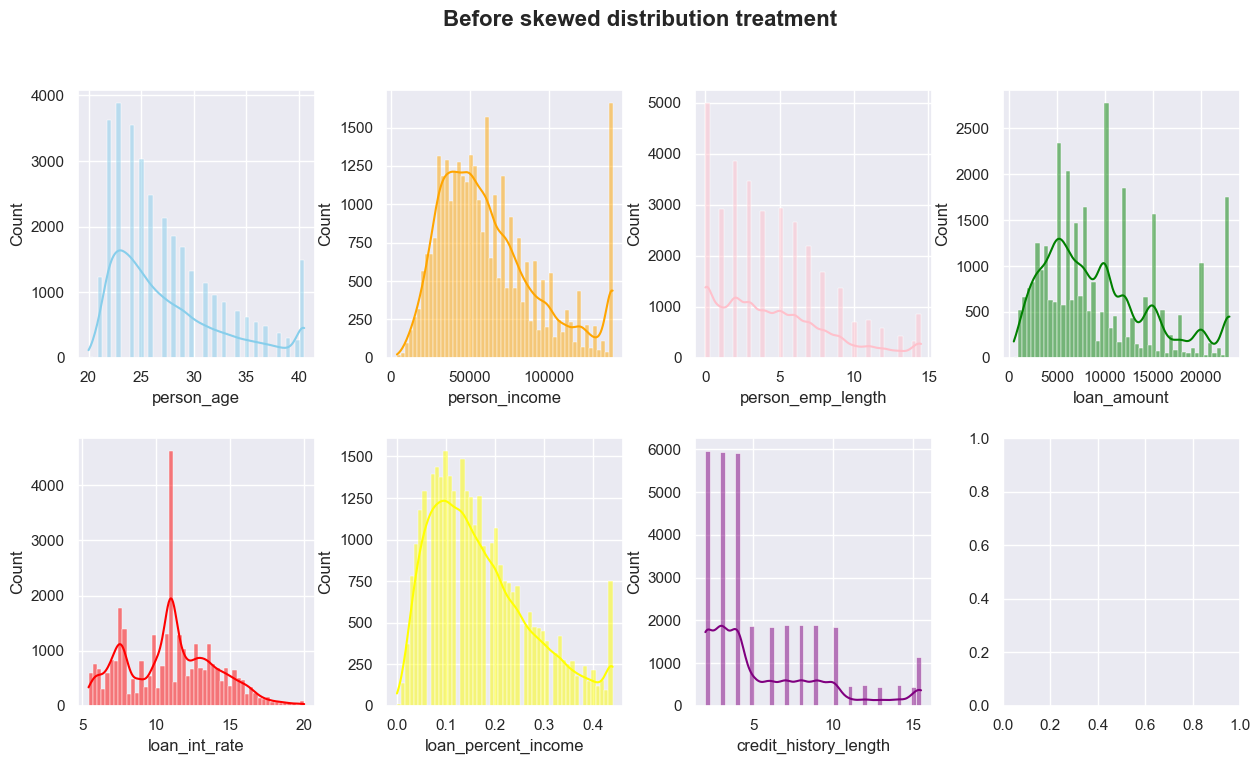

In [337]:
sns.set(style="darkgrid")
fig, axs = plt.subplots(2, 4, figsize=(15, 8), sharex= False)

sns.histplot(data=df, x="person_age", kde=True, ax=axs[0, 0], color='skyblue')
sns.histplot(data=df, x="person_income", kde=True, ax=axs[0, 1], color='orange')
sns.histplot(data=df, x="person_emp_length", kde=True, ax=axs[0, 2], color='pink')
sns.histplot(data=df, x="loan_amount", kde=True, ax=axs[0, 3], color='green')
sns.histplot(data=df, x="loan_int_rate", kde=True, ax=axs[1, 0], color='red')
sns.histplot(data=df, x="loan_percent_income", kde=True, ax=axs[1, 1], color='yellow')
sns.histplot(data=df, x="credit_history_length", kde=True, ax=axs[1, 2], color='purple')

fig.suptitle("Before skewed distribution treatment", fontsize=16, fontweight='bold')
fig.subplots_adjust(hspace= 0.3 ,wspace=0.3)

In [338]:
# Square Root Transformation 

df.person_age = np.sqrt(df.person_age)
df.person_income = np.sqrt(df.person_income)
df.person_emp_length = np.sqrt(df.person_emp_length)
df.loan_amount = np.sqrt(df.loan_amount)
df.loan_int_rate = np.sqrt(df.loan_int_rate)
df.loan_percent_income = np.sqrt(df.loan_percent_income)
df.credit_history_length = np.sqrt(df.credit_history_length)

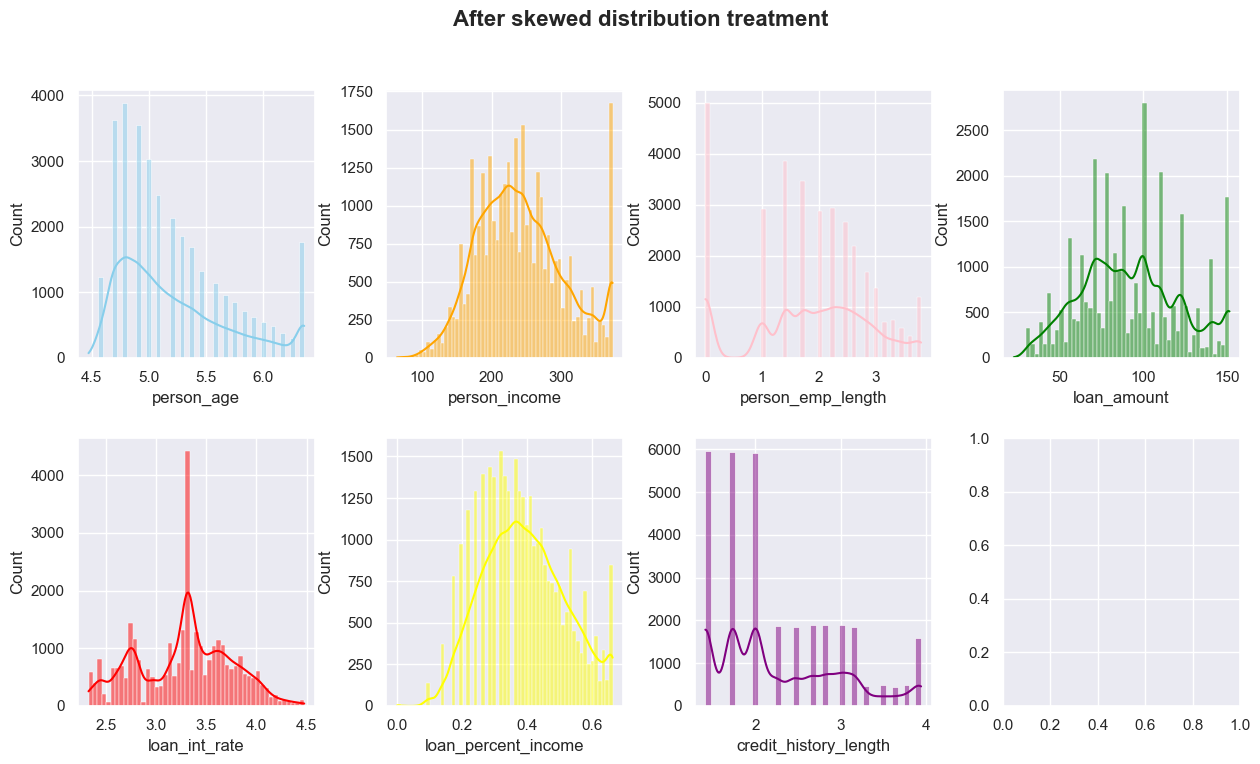

In [339]:
sns.set(style="darkgrid")
fig, axs = plt.subplots(2, 4, figsize=(15, 8), sharex= False)

sns.histplot(data=df, x="person_age", kde=True, ax=axs[0, 0], color='skyblue')
sns.histplot(data=df, x="person_income", kde=True, ax=axs[0, 1], color='orange')
sns.histplot(data=df, x="person_emp_length", kde=True, ax=axs[0, 2], color='pink')
sns.histplot(data=df, x="loan_amount", kde=True, ax=axs[0, 3], color='green')
sns.histplot(data=df, x="loan_int_rate", kde=True, ax=axs[1, 0], color='red')
sns.histplot(data=df, x="loan_percent_income", kde=True, ax=axs[1, 1], color='yellow')
sns.histplot(data=df, x="credit_history_length", kde=True, ax=axs[1, 2], color='purple')

fig.suptitle("After skewed distribution treatment", fontsize=16, fontweight='bold')
fig.subplots_adjust(hspace= 0.3 ,wspace=0.3)

## 5.5 Features Separating 

#### 🧡💚 กำหนดตัวแปรอิสระ (X) และ ตัวแปรตาม(y)

In [340]:
df

,person_age,person_income,person_emp_length,loan_amount,loan_int_rate,loan_percent_income,credit_history_length,loan_status,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,...,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,historical_default
0,4.690416,242.899156,3.807887,151.657509,4.002499,0.663325,1.732051,1,0,0,...,1,0,0,0,0,1,0,0,0,1
1,4.582576,97.979590,2.236068,31.622777,3.337664,0.316228,1.414214,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,5.000000,97.979590,1.000000,74.161985,3.587478,0.663325,1.732051,1,1,0,...,0,0,0,0,1,0,0,0,0,0
3,4.795832,255.929678,2.000000,151.657509,3.902563,0.663325,1.414214,1,0,0,...,0,0,0,0,1,0,0,0,0,0
4,4.898979,233.238076,2.828427,151.657509,3.777565,0.663325,2.000000,1,0,0,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32576,6.363961,230.217289,1.000000,76.157731,3.627671,0.331662,3.937004,0,1,0,...,1,0,0,0,1,0,0,0,0,0
32577,6.363961,346.410162,2.000000,132.759180,2.736786,0.387298,3.937004,0,1,0,...,1,0,1,0,0,0,0,0,0,0
32578,6.363961,275.680975,1.732051,151.657509,3.315117,0.663325,3.937004,1,0,0,...,0,0,0,1,0,0,0,0,0,0
32579,6.363961,374.499666,2.236068,122.474487,3.388215,0.316228,3.937004,0,1,0,...,1,0,0,1,0,0,0,0,0,0


In [341]:
X = df.drop(["loan_status"], axis=1)
y = df["loan_status"]

In [342]:
# --- ก่อนแบ่งข้อมูล train/test ให้เก็บชื่อ column ไว้ ---
feature_names = X.columns  # สมมติว่า X เป็น DataFrame ก่อนแบ่งข้อมูล
feature_names

Index(['person_age', 'person_income', 'person_emp_length', 'loan_amount',
       'loan_int_rate', 'loan_percent_income', 'credit_history_length',
       'person_home_ownership_MORTGAGE', 'person_home_ownership_OTHER',
       'person_home_ownership_OWN', 'person_home_ownership_RENT',
       'loan_intent_DEBTCONSOLIDATION', 'loan_intent_EDUCATION',
       'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL',
       'loan_intent_PERSONAL', 'loan_intent_VENTURE', 'loan_grade_A',
       'loan_grade_B', 'loan_grade_C', 'loan_grade_D', 'loan_grade_E',
       'loan_grade_F', 'loan_grade_G', 'historical_default'],
      dtype='object')

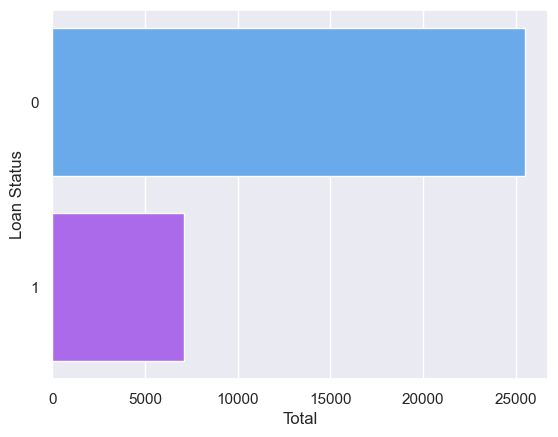

In [343]:
sns.set(style="darkgrid")
sns.countplot(y=y, data=X, palette="cool")
plt.ylabel('Loan Status')
plt.xlabel('Total')
plt.show()

In [344]:
class_counts = y.value_counts()
class_counts

0    25473
1     7108
Name: loan_status, dtype: int64

In [345]:
class_proportions = class_counts / len(y)
class_proportions

0    0.781836
1    0.218164
Name: loan_status, dtype: float64

In [346]:
print("Class Counts:\n", class_counts)
print("\nClass Proportions:\n", class_proportions)

Class Counts:
 0    25473
1     7108
Name: loan_status, dtype: int64

Class Proportions:
 0    0.781836
1    0.218164
Name: loan_status, dtype: float64


* **จะเห็นได้ว่า Minority Class (loan_status = 1) มีสัดส่วนน้อยกว่า Majority Class (loan_status = 0)**
* **โดยสัดส่วน Minority Class (loan_status = 1)  มี 21.8%**
* **สัดส่วน Majority Class (loan_status = 0) มีถึง 78.1%** 

**------แก้ปัญหานี้อย่างไร----------**
 * **จะต้องใช้SMOTE Technique ซึ่งเป็นเทคนิคการสุ่มตัวอย่างเพิ่ม (Oversampling) เพื่อหลีกเลี่ยงปัญหาการเรียนรู้จำเพาะ (Overfitting)**
 * จะแสดงในหัวข้อ 5.7 

## 5.7 SMOTE Technique 

    💚 จากการสำรวจข้อมูลก่อนหน้านี้ สามารถเห็นได้ว่า จำนวน loan_status นั้นไม่สมดุลกัน
    💚 ในส่วนนี้จึงใช้เทคนิคการสุ่มตัวอย่างเพิ่ม (Oversampling) เพื่อหลีกเลี่ยงปัญหาการเรียนรู้จำเพาะ (Overfitting)

**SMOTE ทำงานโดยการสร้างข้อมูลสังเคราะห์ (Synthetic Data) ขึ้นมาใหม่สำหรับคลาสที่มีส่วนน้อย (Minority Class) 
โดยอ้างอิงจากข้อมูลเดิมที่มีอยู่**

**วิธีการทำงานของ SMOTE มีดังนี้**

1. สำหรับแต่ละตัวอย่างข้อมูลในคลาสที่มีส่วนน้อย จะค้นหาเพื่อนบ้านที่ใกล้ที่สุด (nearest neighbors) จากข้อมูลในคลาสเดียวกัน
2. สุ่มเลือกจุดบนเวกเตอร์ระหว่างตัวอย่างข้อมูลและเพื่อนบ้านที่ใกล้ที่สุด
3. สร้างตัวอย่างข้อมูลสังเคราะห์ใหม่ขึ้นมาบนจุดที่สุ่มได้
4. ทำซ้ำขั้นตอนที่ 2 และ 3 จนกว่าจะได้จำนวนตัวอย่างข้อมูลสังเคราะห์ที่ต้องการสำหรับคลาสส่วนน้อย


- SMOTE (Synthetic Minority Over-sampling Technique) เป็นเทคนิคที่ใช้ในการจัดการกับปัญหาข้อมูลที่ไม่สมดุล (Imbalanced Data) 
- โดยเฉพาะในกรณีที่ข้อมูลของคลาสส่วนน้อย (Minority Class) มีจำนวนน้อยมากเมื่อเทียบกับคลาสส่วนใหญ่ (Majority Class)
- การใช้ SMOTE จะช่วยเพิ่มจำนวนตัวอย่างข้อมูลของคลาสส่วนน้อย ทำให้ชุดข้อมูลมีความสมดุลมากขึ้น ซึ่งจะส่งผลให้ประสิทธิภาพของอัลกอริทึมการเรียนรู้ของเครื่อง (Machine Learning Algorithms) ดีขึ้น
- อย่างไรก็ตาม SMOTE มีข้อจำกัดบางประการ เช่น การสร้างข้อมูลสังเคราะห์นั้นมีความเสี่ยงที่จะทำให้เกิด overfitting และการเพิ่มจำนวนข้อมูลสังเคราะห์มากเกินไปอาจทำให้ประสิทธิภาพของอัลกอริทึมลดลงได้ จึงควรใช้เทคนิคนี้ด้วยความระมัดระวัง

In [347]:
# 2. กำหนดสัดส่วน minority class เป็น 85% ของ majority class
smote = SMOTE(sampling_strategy=0.85, random_state=33)
X, y= smote.fit_resample(X, y)

# ✅ จากการทดลอง พบว่าสัดส่วน minority class >85 % ของ majority class  -- >> เกิด underfitting 


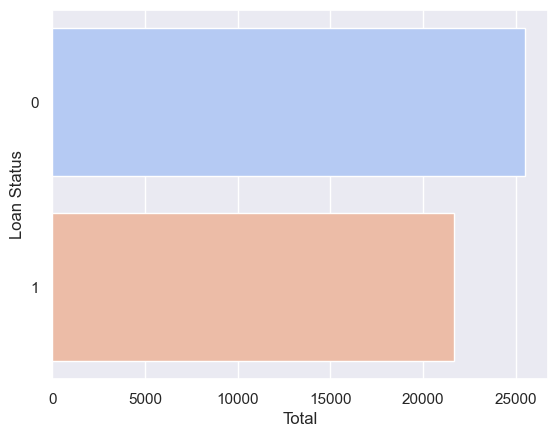

In [348]:
sns.set(style="darkgrid")
sns.countplot(y=y, data=X, palette="coolwarm")
plt.ylabel('Loan Status')
plt.xlabel('Total')
plt.show()

    💚 หลังจากการทำ SMOTE Technique จะพบว่า Loan Status มีการกระจายตัวที่สมดุลมากขึ้น

## 5.8 Data Normalization

##### 💛 ในส่วนนี้ จะมีการทำการ Data Normalization เพื่อปรับช่วงของตัวแปรอิสระ(X)หรือคุณลักษณะของข้อมูลให้อยู่ในช่วงปกติ 

    การเลือกใช้เทคนิค Data Normalization ระหว่าง MinMaxScaler() หรือ Standardization 
    นั้นขึ้นอยู่กับลักษณะของข้อมูลและอัลกอริทึมที่จะนำไปใช้ โดยมีข้อแนะนำดังนี้:

    1. MinMaxScaler() 
       - เหมาะสำหรับข้อมูลที่มีค่าพิสัยกว้าง โดยจะแปลงค่าให้อยู่ในช่วง 0 ถึง 1
       - ใช้ได้ดีกับอัลกอริทึมที่ไวต่อช่วงของค่า เช่น อัลกอริทึมที่ใช้ฟังก์ชันเส้นตรงหรือเคอร์เนลเป็นฐาน
       - อาจไม่เหมาะสมสำหรับข้อมูลที่มีค่าเบี่ยงเบนมาก 

    2. Standardization
       - แปลงข้อมูลให้มีค่าเฉลี่ยเป็น 0 และส่วนเบี่ยงเบนมาตรฐานเป็น 1 
       - เหมาะสำหรับข้อมูลที่มีการกระจายตัวแบบปกติ
       - ช่วยลดอิทธิพลของ outliers
       - ใช้ได้ดีกับอัลกอริทึมที่มีการคำนวณระยะห่าง เช่น อัลกอริทึมแบบเพื่อนบ้านใกล้ที่สุด

    โดยทั่วไปแล้ว ถ้าไม่แน่ใจว่าข้อมูลมีลักษณะอย่างไร การใช้ Standardization มักให้ผลที่ดีกว่า MinMaxScaler() เนื่องจากช่วยลดอิทธิพลของค่า outliers ได้ดีกว่า 
    อย่างไรก็ตาม การทดลองทั้งสองวิธีกับข้อมูลที่มีก็เป็นสิ่งที่ดี เพื่อเลือกวิธีที่ให้ผลดีที่สุดสำหรับชุดข้อมูลนั้นๆ

##### 💛 ในที่นี้จะเลือกใช้ StandardScaler() 

In [349]:
# X =  MinMaxScaler().fit_transform(X)

In [350]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)

In [351]:
X

array([[-1.10059175,  0.17076613,  1.96195   , ..., -0.07703383,
        -0.04019126,  2.26664202],
       [-1.33330906, -2.13547398,  0.42502826, ..., -0.07703383,
        -0.04019126, -0.44118127],
       [-0.43251339, -2.13547398, -0.78359708, ..., -0.07703383,
        -0.04019126, -0.44118127],
       ...,
       [ 1.26153891, -1.02849278, -0.16003718, ..., -0.07703383,
        -0.04019126, -0.44118127],
       [ 0.28907569,  0.17076613,  0.13927666, ..., -0.07703383,
        -0.04019126, -0.44118127],
       [-0.34660993, -0.24465627,  0.87848791, ..., -0.07703383,
        -0.04019126, -0.44118127]])

In [352]:
y

0        1
1        0
2        1
3        1
4        1
        ..
47120    1
47121    1
47122    1
47123    1
47124    1
Name: loan_status, Length: 47125, dtype: int64

# 6. สร้างและเทรนโมเดล (Model Building and Training)

**คำอธิบาย:  จะสร้างโมเดล 2 แบบ นั่นคือ**
* โมเดล Linear model ได้แก่ Logistic Regression
* โมเดล Non-linear model ได้แก่ Decision Tree Classifier, Random Forest Classifier

## 6.1 Splitting Dataset

##### 💚 80% train และ 20% test.

In [353]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## 6.2 สร้างโมเดลแบบต่างๆ 

**💚💖ขั้นตอนการทำงานของโมเดล**
1. กำหนดโมเดล :
    * Logistic Regression, Decision tree classifier, Random forest classifier 
    * โดยตั้งค่า random_state เพื่อให้ผลลัพธ์คงที่
2. การกำหนด parameter grid : 
    * กำหนดค่าพารามิเตอร์ที่จะใช้ในการ tune โมเดล 
3. Nested Cross-Validation : 
    * ใช้ Nested Cross-Validation โดยมี outer loop และ inner loop 
    * แบ่งข้อมูลเป็น 5 ส่วนเท่าๆ กัน 
4. การหา Best Parameters และ Best Model: 
    * ใช้ GridSearchCV เพื่อหาพารามิเตอร์ที่ดีที่สุดใน inner loop 
    * และเทรนโมเดลด้วย training set
5. การเก็บและแสดงผลลัพธ์ : 
    * เก็บผลลัพธ์จาก Nested Cross-Validation และแสดงผล
6. การประเมิน Overfitting และ underfitting: 
    * เปรียบเทียบ accuracy ระหว่าง training set และ validation set 
    * ลักษณะของ **Overfitting** คือ โมเดลจดจำข้อมูลจาก training set มากเกินไป จนไม่สามารถทำนายข้อมูลอื่นได้แม่นยำเท่าเดิม 
       นั่นทำให้ค่า accuracy ของ training set จะสูงกว่า validation set  มากๆ เช่น 0.90 และ 0.70 ตามลำดับ
    * ลักษณะของ **Underfitting** คือ โมเดลจะทำนายไม่เก่ง เอาข้อมูล test set มาทำนาย ผลจะออกมาแม่นยำสูงตลอด 
       สังเกตจาก ค่า accuracy ของ training set จะต่ำกว่า validation set  
    * เพื่อดูว่าโมเดล generalize หรือยัง (ถ้า generalize คือ ไม่เกิด overfitting และ underfitting) 
7. การ Train Final Model :  
    * ใช้โมเดลที่ดีที่สุดจาก GridSearchCV (โมเดลที่ generalize แล้ว) มา train บนข้อมูล trainng set ทั้งหมด 
8. ประเมินผลบน Test Set:
    * ประเมินผลบน test set 
9. คำนวณ metrics
    * accuracy, precision, recall, และ F1-score

### 6.2.1 Logistic Regression 

In [354]:
# --- Logistic Regression ---
print("----- Logistic Regression -----")

# ขั้นตอน(1) กำหนดโมเดล  Logistic Regression
model_lr = LogisticRegression(random_state=0)

#ขั้นตอน(2) กำหนด parameter grid เพื่อหาพารามิเตอร์ที่เหมาะสมที่สุด 
param_grid_lr = {'C': [0.05, 0.1, 0.5, 1], 'penalty': ['l1', 'l2']}

# ขั้นตอน(3-4) Nested Cross-Validation 
outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)

nested_scores_lr = []
for train_index, test_index in outer_cv.split(X, y):
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    model_cv_lr = GridSearchCV(model_lr, param_grid_lr, cv=inner_cv, scoring='accuracy')
    model_cv_lr.fit(X_train_fold, y_train_fold)

    y_pred_cv_lr = model_cv_lr.predict(X_test_fold)
    accuracy_lr = accuracy_score(y_test_fold, y_pred_cv_lr)
    nested_scores_lr.append(accuracy_lr)

# ขั้นตอน(5) เก็บผลลัพธ์ nested cross-validation
results_lr = {
    'cv_accuracy': np.mean(nested_scores_lr),
    'best_params': model_cv_lr.best_params_,
    'best_model': model_cv_lr.best_estimator_
}

# แสดงผลลัพธ์ nested cross-validation
print(f"Best Parameters: {results_lr['best_params']}\n")
print("Nested Cross-Validation Accuracy scores:", nested_scores_lr)
print(f"Average Accuracy (Validation Set): {results_lr['cv_accuracy']:.4f}")

# ขั้นตอน(6) ประเมินผล Overfitting
model_train_lr = LogisticRegression(**results_lr['best_params'], random_state=0) #ใช้พารามิเตอร์ที่ดีที่สุดจาก nested cross-validation
model_train_lr.fit(X_train, y_train)

y_pred_train_lr = model_train_lr.predict(X_train)
train_accuracy_lr = accuracy_score(y_train, y_pred_train_lr)
print(f"Accuracy (Training Set): {train_accuracy_lr:.4f}")
print(f"Accuracy diff: {train_accuracy_lr - results_lr['cv_accuracy']:.4f}\n")

# ขั้นตอน(7) Train Final Model
final_model_lr = results_lr['best_model']
final_model_lr.fit(X_train, y_train)

# ขั้นตอน(8)ประเมินผล Final Model บน test set
y_pred_lr = final_model_lr.predict(X_test)

# ขั้นตอน(9) คำนวณ metrics
test_accuracy_lr = accuracy_score(y_test, y_pred_lr)
test_precision_lr = precision_score(y_test, y_pred_lr)
test_recall_lr = recall_score(y_test, y_pred_lr)
test_f1_lr = f1_score(y_test, y_pred_lr)

# แสดงผลลัพธ์ metrics
print(f"Accuracy (Test Set): {test_accuracy_lr:.4f}")
print(f"Precision (Test Set): {test_precision_lr:.4f}")
print(f"Recall (Test Set): {test_recall_lr:.4f}")
print(f"F1-score (Test Set): {test_f1_lr:.4f}\n")

----- Logistic Regression -----
Best Parameters: {'C': 0.5, 'penalty': 'l2'}

Nested Cross-Validation Accuracy scores: [0.8957029177718833, 0.896657824933687, 0.8954907161803713, 0.8992042440318302, 0.8952785145888594]
Average Accuracy (Validation Set): 0.8965
Accuracy (Training Set): 0.8971
Accuracy diff: 0.0006

Accuracy (Test Set): 0.8953
Precision (Test Set): 0.9215
Recall (Test Set): 0.8444
F1-score (Test Set): 0.8812



### 💖Feature Importance for Logistic Regression
* Logistic Regression ไม่มี feature importance ในแบบเดียวกับ Tree-based models
* แต่เราสามารถดูค่า coefficients ได้ ซึ่งบ่งบอกถึงน้ำหนักของ featureในการตัดสินใจของโมเดล
    * ค่า positive หมายถึง feature นั้น **เพิ่มโอกาสในการผิดนัดชำระหนี้**
    * ค่า negative หมายถึง feature นั้น **ลดโอกาสในการผิดนัดชำระหนี้**


Feature ranking (Logistic Regression - Coefficients):
1. feature loan_grade_A (-3.027537)
2. feature loan_grade_B (-2.960412)
3. feature person_home_ownership_MORTGAGE (-2.505602)
4. feature loan_intent_EDUCATION (-2.480383)
5. feature loan_intent_VENTURE (-2.420036)
6. feature loan_grade_C (-2.391434)
7. feature person_home_ownership_RENT (-2.281083)
8. feature loan_intent_PERSONAL (-2.270661)
9. feature loan_intent_MEDICAL (-2.261798)
10. feature loan_intent_DEBTCONSOLIDATION (-2.074217)
11. feature loan_percent_income (1.738572)
12. feature loan_intent_HOMEIMPROVEMENT (-1.705157)
13. feature person_home_ownership_OWN (-1.643908)
14. feature loan_grade_D (-1.449930)
15. feature loan_amount (-0.878175)
16. feature loan_grade_E (-0.660646)
17. feature loan_grade_F (-0.306785)
18. feature person_home_ownership_OTHER (-0.242586)
19. feature loan_int_rate (0.181475)
20. feature person_income (0.096256)
21. feature person_emp_length (-0.069709)
22. feature historical_default (-0.036336)
2

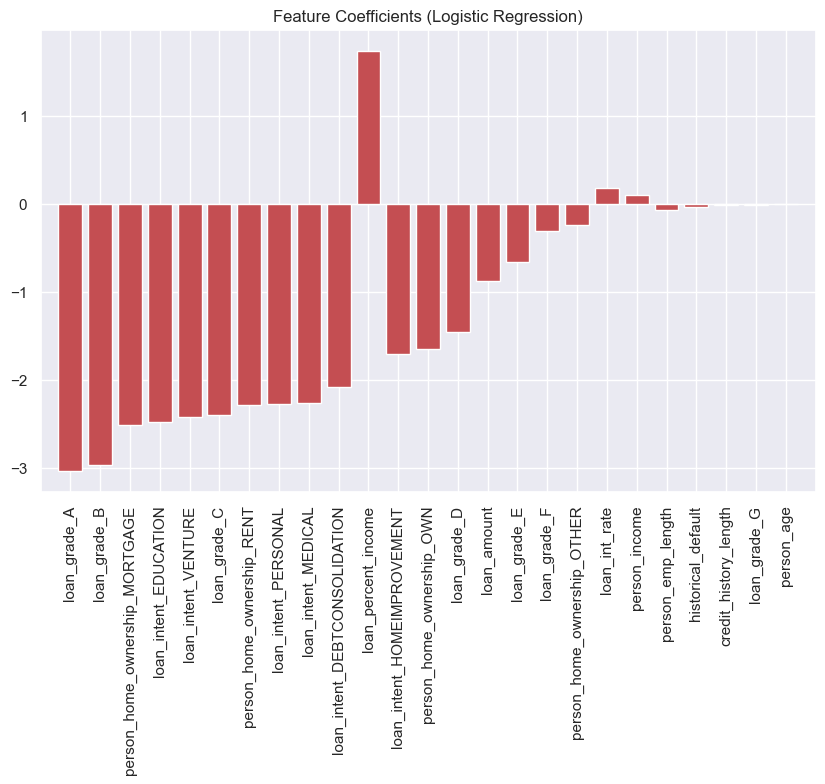

In [355]:
# --- Feature Importance for Logistic Regression ---

importances_lr = final_model_lr.coef_[0]
indices_lr = np.argsort(abs(importances_lr))[::-1]

print("\nFeature ranking (Logistic Regression - Coefficients):")
for f in range(X_train.shape[1]): 
    # ใช้ feature_names ที่เก็บไว้
    print("%d. feature %s (%f)" % (f + 1, feature_names[indices_lr[f]], importances_lr[indices_lr[f]]))

# พล็อตกราฟ coefficients
plt.figure(figsize=(10, 6))
plt.title("Feature Coefficients (Logistic Regression)")
plt.bar(range(X_train.shape[1]), importances_lr[indices_lr], color="r", align="center") 
plt.xticks(range(X_train.shape[1]), feature_names[indices_lr], rotation=90) 
plt.xlim([-1, X_train.shape[1]]) 
plt.show()

### 💚 แปลผล Feature Importances (Logistic Regression)

จากผลลัพธ์จะเห็นว่าโมเดล Logistic Regression มองเห็นความสัมพันธ์ระหว่าง features ต่างๆ กับความเสี่ยงในการผิดนัดชำระหนี้ ดังนี้

**🔺Features สำคัญที่เพิ่มโอกาสผิดนัด (ค่าเป็นบวก)**

* **loan_percent_income**:  ยิ่งสัดส่วนของเงินกู้ต่อรายได้สูง ยิ่งมีโอกาสผิดนัด **มาก**
* **loan_int_rate**: ยิ่งอัตราดอกเบี้ยสูง ยิ่งมีแนวโน้มผิดนัด **มาก**
* **person_income**: ยิ่งมีรายได้สูง อาจมีความเสี่ยงในการผิดนัดชำระหนี้**เพิ่มขึ้น** (ผู้ที่มีรายได้สูง อาจมีภาระหนี้สินอื่นๆ สูงตามไปด้วย เช่น ผ่อนบ้านราคาแพง, รถยนต์หลายคัน หรือแม้กระทั่งพฤติกรรมการใช้จ่ายอาจเปลี่ยนไป: รายได้มากขึ้น อาจใช้จ่ายมากขึ้น ทำให้บริหารจัดการเงินยากขึ้น)

**🔻Features สำคัญที่ลดโอกาสผิดนัด (ค่าเป็นลบสูง)** 

* **loan_grade_A**: ผู้กู้ที่มี loan grade A มีโอกาสผิดนัด **น้อยที่สุด** ตามคาด 
* **loan_grade_B**:  ผู้กู้ที่มี loan grade B  มีโอกาสผิดนัด **น้อย** เช่นกัน  (แม้จะน้อยกว่า A เล็กน้อย)
* **person_home_ownership_MORTGAGE**: ผู้กู้ที่ผ่อนบ้านอยู่ มีโอกาสผิดนัด **น้อยกว่า** ผู้ที่เช่าบ้านหรือเป็นเจ้าของบ้าน (ความสัมพันธ์ที่เป็น Correlation ไม่ใช่ Causation การที่ person_home_ownership_MORTGAGE มีค่า coefficient เป็นลบ ไม่ได้แปลว่า การผ่อนบ้าน เป็นสาเหตุโดยตรงที่ทำให้ความเสี่ยงการผิดนัดลดลงอาจมีปัจจัยอื่นๆ ที่สัมพันธ์กับทั้งการผ่อนบ้านและความเสี่ยงการผิดนัดชำระหนี้)

**💛Features ที่มีอิทธิพลน้อย (ใกล้ 0)**

* **person_age**, **credit_history_length**:  อายุ และ ระยะเวลาประวัติเครดิต  ดูจะมีผลน้อยต่อการทำนาย

**✅ข้อสรุป:**
* **loan_percent_income  เด่นชัด**   เน้นย้ำถึงความสำคัญของฐานะทางการเงิน
* **loan_percent_income  และ  loan_int_rate**   อาจต้องพิจารณามากขึ้น เพราะมีอิทธิพลสูงต่อการ **ผิดชำระหนี้**
* **loan_grade  ยังคงมีอิทธิพล**    เกรด A และ B  บ่งชี้ถึงความเสี่ยงต่ำ 


### 6.2.2 Decision tree classifier

In [356]:
# --- Decision Tree ---
print("----- Decision Tree -----")

#  ขั้นตอน(1) กำหนดโมเดล
model_dt = DecisionTreeClassifier(random_state=0)

#  ขั้นตอน(2) กำหนด parameter grid
param_grid_dt = {'max_depth': [5,7,9], 'min_samples_split': [35, 40,50], 'min_samples_leaf': [5, 7, 9]}

#  ขั้นตอน(3-4) Nested Cross-Validation
outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)

nested_scores_dt = []
for train_index, test_index in outer_cv.split(X, y):
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    model_cv_dt = GridSearchCV(model_dt, param_grid_dt, cv=inner_cv, scoring='accuracy')
    model_cv_dt.fit(X_train_fold, y_train_fold)

    y_pred_cv_dt = model_cv_dt.predict(X_test_fold)
    accuracy_dt = accuracy_score(y_test_fold, y_pred_cv_dt)
    nested_scores_dt.append(accuracy_dt)

#  ขั้นตอน(5) เก็บผลลัพธ์ nested cross-validation
results_dt = {
    'cv_accuracy': np.mean(nested_scores_dt),
    'best_params': model_cv_dt.best_params_,
    'best_model': model_cv_dt.best_estimator_
}

# แสดงผลลัพธ์ nested cross-validation
print(f"Best Parameters: {results_dt['best_params']}\n")
print("Nested Cross-Validation Accuracy scores:", nested_scores_dt)
print(f"Average Accuracy (Validation Set): {results_dt['cv_accuracy']:.4f}")

#  ขั้นตอน(6) ประเมินผล Overfitting
model_train_dt = DecisionTreeClassifier(**results_dt['best_params'], random_state=0)
model_train_dt.fit(X_train, y_train)

y_pred_train_dt = model_train_dt.predict(X_train)
train_accuracy_dt = accuracy_score(y_train, y_pred_train_dt)
print(f"Accuracy (Training Set): {train_accuracy_dt:.4f}")
print(f"Accuracy diff: {train_accuracy_dt - results_dt['cv_accuracy']:.4f}\n")

#  ขั้นตอน(7)Train Final Model
final_model_dt = results_dt['best_model']
final_model_dt.fit(X_train, y_train)

# ขั้นตอน(8) ประเมินผล Final Model บน test set
y_pred_dt = final_model_dt.predict(X_test)

# ขั้นตอน(9) คำนวณ metrics
test_accuracy_dt = accuracy_score(y_test, y_pred_dt)
test_precision_dt = precision_score(y_test, y_pred_dt)
test_recall_dt = recall_score(y_test, y_pred_dt)
test_f1_dt = f1_score(y_test, y_pred_dt)

#  แสดงผลลัพธ์ metrics
print(f"Accuracy (Test Set): {test_accuracy_dt:.4f}")
print(f"Precision (Test Set): {test_precision_dt:.4f}")
print(f"Recall (Test Set): {test_recall_dt:.4f}")
print(f"F1-score (Test Set): {test_f1_dt:.4f}\n")

----- Decision Tree -----
Best Parameters: {'max_depth': 9, 'min_samples_leaf': 7, 'min_samples_split': 40}

Nested Cross-Validation Accuracy scores: [0.9189389920424403, 0.9263660477453581, 0.9218037135278515, 0.923501326259947, 0.9201061007957559]
Average Accuracy (Validation Set): 0.9221
Accuracy (Training Set): 0.9275
Accuracy diff: 0.0054

Accuracy (Test Set): 0.9184
Precision (Test Set): 0.9660
Recall (Test Set): 0.8527
F1-score (Test Set): 0.9058



### 🧡 Feature Importance for Decision Tree 
* ใช้ feature_importances_ เพื่อดึงค่าความสำคัญของ feature
* ค่าที่สูงกว่าบ่งบอกถึงความสำคัญที่มากขึ้นในการทำนาย



Feature ranking (Decision Tree):
1. feature loan_percent_income (0.241524)
2. feature loan_int_rate (0.182826)
3. feature loan_grade_C (0.169487)
4. feature person_income (0.101707)
5. feature loan_grade_B (0.072325)
6. feature person_home_ownership_MORTGAGE (0.044363)
7. feature loan_grade_A (0.039126)
8. feature person_home_ownership_OWN (0.035296)
9. feature person_emp_length (0.019294)
10. feature loan_intent_VENTURE (0.019059)
11. feature loan_intent_EDUCATION (0.014816)
12. feature person_home_ownership_RENT (0.014528)
13. feature loan_intent_PERSONAL (0.013671)
14. feature loan_intent_HOMEIMPROVEMENT (0.013187)
15. feature loan_grade_D (0.008334)
16. feature person_age (0.002964)
17. feature loan_amount (0.002319)
18. feature loan_grade_E (0.001798)
19. feature credit_history_length (0.001609)
20. feature loan_grade_F (0.001082)
21. feature loan_intent_MEDICAL (0.000434)
22. feature loan_intent_DEBTCONSOLIDATION (0.000252)
23. feature person_home_ownership_OTHER (0.000000)
24. 

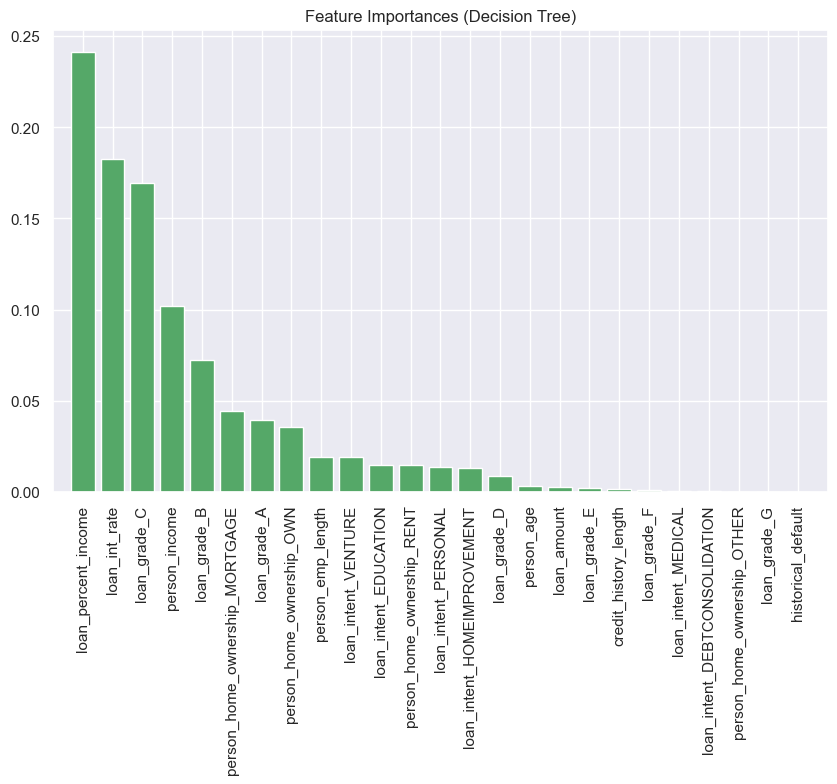

In [357]:
# --- Feature Importance for Decision Tree ---
importances_dt = final_model_dt.feature_importances_
indices_dt = np.argsort(importances_dt)[::-1]

print("\nFeature ranking (Decision Tree):")
for f in range(X_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, feature_names[indices_dt[f]], importances_dt[indices_dt[f]]))

# พล็อตกราฟ Feature Importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Decision Tree)")
plt.bar(range(X_train.shape[1]), importances_dt[indices_dt], color="g", align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices_dt], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

### 🧡แปลผล Feature Importances (Decision Tree)

ผลลัพธ์จาก Decision Tree แสดงให้เห็นว่า โมเดลมองเห็นความสำคัญของ Features ในการทำนายความเสี่ยงผิดนัดชำระหนี้ แตกต่างจาก Logistic Regression เล็กน้อย

**🔺Features สำคัญที่สุด (มีโอกาสผิดนัดชำระหนี้สูง)**

*  **loan_percent_income (0.241524):** ยิ่งสัดส่วนเงินกู้ต่อรายได้สูง ยิ่งมีแนวโน้มผิดนัดชำระหนี้ **มากที่สุด** สอดคล้องกับความเป็นจริงและผลลัพธ์ของ Logistic Regression 
*  **loan_int_rate (0.182826):**  อัตราดอกเบี้ยสูง บ่งชี้ถึงความเสี่ยงสูงในการผิดนัดชำระหนี้เช่นกัน 
*  **loan_grade_C (0.169487):**   ผู้กู้ที่มี loan grade C  มีแนวโน้มผิดนัดสูง เป็นอันดับ 3 

**🔻Features ที่มีความสำคัญรองลงมา**

*   **person_income (0.101707):**  แม้จะเป็นค่าบวก  แต่ความสำคัญลดลงมาอยู่ที่อันดับ 4  บ่งชี้ว่า Decision Tree อาจไม่ได้ให้ น้ำหนักกับรายได้มากเท่ากับ Logistic Regression 
*   **loan_grade  อื่นๆ**:   เกรด B, A,  MORTGAGE, OWN  ก็ยังมีความสำคัญในการทำนาย  
*   **person_emp_length (0.019294):**   ระยะเวลาการทำงาน  เริ่มมีความสำคัญมากขึ้น  เมื่อเทียบกับ  Logistic Regression 

**💛Features ที่แทบไม่มีผล (ใกล้ 0)**

*   **historical_default**:  ประวัติการผิดนัดชำระหนี้ในอดีต  กลับไม่มีผลต่อการทำนายในโมเดล Decision Tree นี้  อาจเป็นเพราะ features อื่นๆ มีความสำคัญมากกว่า  หรือข้อมูลมี Pattern ที่ซับซ้อน

**✅ข้อสรุป**

*   **Decision Tree Model** ให้ความสำคัญกับ  **loan_percent_income  และ  loan_int_rate   มากที่สุด  สอดคล้องกับ  Logistic Regression**
*   loan_grade   ยังคงเป็นปัจจัยสำคัญ   แต่  Decision Tree  อาจให้ น้ําหนักกับแต่ละเกรดต่างกัน 
*   person_income  มีความสำคัญลดลง   
*   บาง features  ที่ไม่สำคัญใน  Logistic Regression  (เช่น  person_emp_length)   อาจมีความสำคัญขึ้นใน  Decision Tree 

### 6.2.3 Random forest classifier

In [358]:
# --- Random Forest ---
print("----- Random Forest -----")

# ขั้นตอน(1) กำหนดโมเดล
model_rf = RandomForestClassifier(random_state=0)

# ขั้นตอน(2) กำหนด parameter grid
param_grid_rf = {'n_estimators': [200], 'max_depth': [10, 12], 'min_samples_split': [25, 30], 'min_samples_leaf': [4, 7]}

# ขั้นตอน(3-4) Nested Cross-Validation
outer_cv = KFold(n_splits=5, shuffle=True, random_state=0)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)

nested_scores_rf = []
for train_index, test_index in outer_cv.split(X, y):
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    model_cv_rf = GridSearchCV(model_rf, param_grid_rf, cv=inner_cv, scoring='accuracy')
    model_cv_rf.fit(X_train_fold, y_train_fold)
    
    y_pred_cv_rf = model_cv_rf.predict(X_test_fold)
    accuracy_rf = accuracy_score(y_test_fold, y_pred_cv_rf)
    nested_scores_rf.append(accuracy_rf)

# ขั้นตอน(5) เก็บผลลัพธ์ nested cross-validation
results_rf = {
    'cv_accuracy': np.mean(nested_scores_rf),
    'best_params': model_cv_rf.best_params_,
    'best_model': model_cv_rf.best_estimator_
}

# แสดงผลลัพธ์ nested cross-validation
print(f"Best Parameters: {results_rf['best_params']}\n")
print("Nested Cross-Validation Accuracy scores:", nested_scores_rf)
print(f"Average Accuracy (Validation Set): {results_rf['cv_accuracy']:.4f}")

# ขั้นตอน(6) ประเมินผล Overfitting
model_train_rf = RandomForestClassifier(**results_rf['best_params'], random_state=0)
model_train_rf.fit(X_train, y_train)

y_pred_train_rf = model_train_rf.predict(X_train)
train_accuracy_rf = accuracy_score(y_train, y_pred_train_rf)
print(f"Accuracy (Training Set): {train_accuracy_rf:.4f}")
print(f"Accuracy diff: {train_accuracy_rf - results_rf['cv_accuracy']:.4f}\n")

# ขั้นตอน(7). Train Final Model
final_model_rf = results_rf['best_model']
final_model_rf.fit(X_train, y_train)

# ขั้นตอน(8) ประเมินผล Final Model บน test set
y_pred_rf = final_model_rf.predict(X_test)

# ขั้นตอน(9) คำนวณ metrics
test_accuracy_rf = accuracy_score(y_test, y_pred_rf)
test_precision_rf = precision_score(y_test, y_pred_rf)
test_recall_rf = recall_score(y_test, y_pred_rf)
test_f1_rf = f1_score(y_test, y_pred_rf)

# แสดงผลลัพธ์ metrics
print(f"Accuracy (Test Set): {test_accuracy_rf:.4f}")
print(f"Precision (Test Set): {test_precision_rf:.4f}")
print(f"Recall (Test Set): {test_recall_rf:.4f}")
print(f"F1-score (Test Set): {test_f1_rf:.4f}\n")

----- Random Forest -----
Best Parameters: {'max_depth': 12, 'min_samples_leaf': 4, 'min_samples_split': 25, 'n_estimators': 200}

Nested Cross-Validation Accuracy scores: [0.9308222811671087, 0.9341114058355438, 0.9324137931034483, 0.9363395225464191, 0.9324137931034483]
Average Accuracy (Validation Set): 0.9332
Accuracy (Training Set): 0.9404
Accuracy diff: 0.0072

Accuracy (Test Set): 0.9304
Precision (Test Set): 0.9782
Recall (Test Set): 0.8681
F1-score (Test Set): 0.9199



### 💛 Feature Importance for Random Forest


Feature ranking (Random Forest):
1. feature loan_percent_income (0.199335)
2. feature loan_int_rate (0.114966)
3. feature person_income (0.099381)
4. feature loan_grade_A (0.095964)
5. feature loan_grade_B (0.084549)
6. feature loan_grade_C (0.080439)
7. feature person_home_ownership_MORTGAGE (0.067389)
8. feature person_home_ownership_OWN (0.036503)
9. feature person_home_ownership_RENT (0.031132)
10. feature loan_amount (0.029387)
11. feature loan_intent_VENTURE (0.028383)
12. feature loan_intent_EDUCATION (0.026401)
13. feature loan_grade_D (0.019239)
14. feature person_emp_length (0.018538)
15. feature loan_intent_PERSONAL (0.017105)
16. feature loan_intent_MEDICAL (0.008702)
17. feature credit_history_length (0.008512)
18. feature loan_intent_HOMEIMPROVEMENT (0.008315)
19. feature person_age (0.008273)
20. feature historical_default (0.007517)
21. feature loan_intent_DEBTCONSOLIDATION (0.006573)
22. feature loan_grade_E (0.002659)
23. feature person_home_ownership_OTHER (0.000320

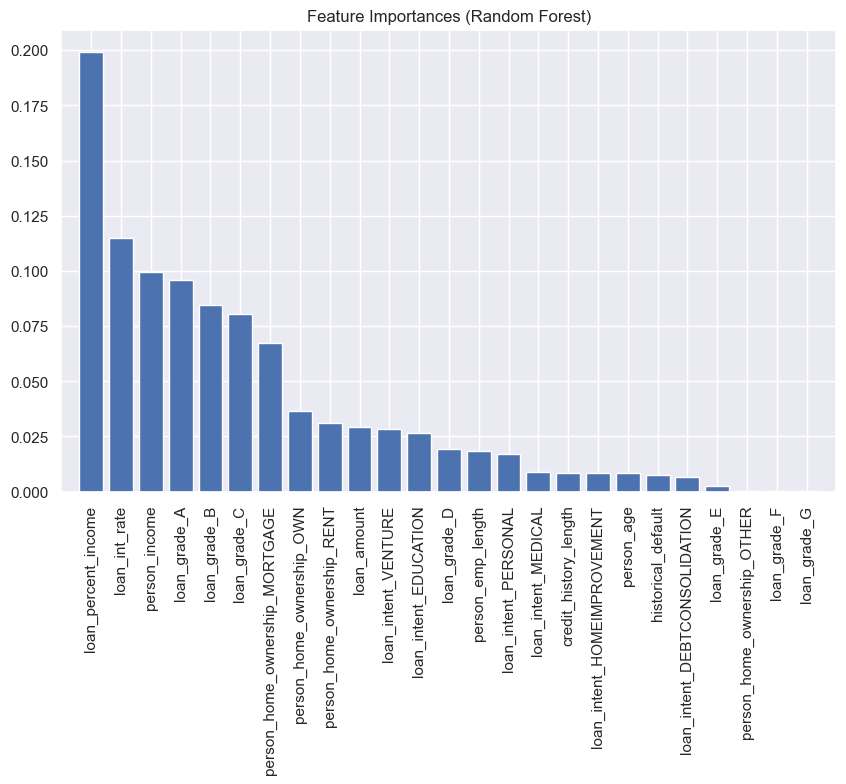

In [364]:
# --- Feature Importance for Random Forest ---
importances_rf = final_model_rf.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]

print("\nFeature ranking (Random Forest):")
for f in range(X_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, feature_names[indices_rf[f]], importances_rf[indices_rf[f]]))

# พล็อตกราฟ Feature Importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Random Forest)")
plt.bar(range(X_train.shape[1]), importances_rf[indices_rf], color="b", align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices_rf], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

### 💛แปลผล Feature Importances (Random Forest)

ผลลัพธ์จาก Random Forest แสดงให้เห็นถึงความสำคัญของ Features ในการทำนายความเสี่ยงผิดนัดชำระหนี้ ซึ่งสอดคล้องกับโมเดล Decision Tree แต่มีรายละเอียดที่น่าสนใจเพิ่มเติม ดังนี้

**🔺Features สำคัญที่สุด (มีโอกาสผิดนัดชำระหนี้สูง)**

* **loan_percent_income (0.199335):**  ยังคงเป็น Feature ที่สำคัญที่สุด ยิ่งสัดส่วนเงินกู้ต่อรายได้สูง ยิ่งมีแนวโน้มผิดนัดชำระหนี้ **มากที่สุด**
* **loan_int_rate (0.114966):** อัตราดอกเบี้ยสูง เป็นตัวบ่งชี้ความเสี่ยงสูง เช่นเดียวกับโมเดล Desion Tree
* **person_income (0.099381):**  Random Forest ให้ความสำคัญกับรายได้ มากกว่า Decision Tree  

**🔻Features ที่มีความสำคัญรองลงมา**

* **loan_grade**: เกรด A, B, C มีความสำคัญสูงสุด ตามลำดับ  แสดงให้เห็นว่า Random Forest อาจมองเห็น Pattern ที่ซับซ้อนขึ้น เกี่ยวกับ loan grade
* **person_home_ownership**: สถานะการเป็นเจ้าของบ้าน  ทั้ง MORTGAGE, OWN, RENT มีความสำคัญ ในการทำนาย
* **loan_amount**: จำนวนเงินกู้ ก็มีความสำคัญในระดับหนึ่ง

**💛Features ที่มีความสำคัญน้อยลง**

* **person_emp_length**, **credit_history_length**, **person_age**:  Features เหล่านี้มีความสำคัญลดลง  เมื่อเทียบกับโมเดล Decision Tree 
* **historical_default**:  Random Forest ให้ความสำคัญกับประวัติการผิดนัดชำระหนี้ในอดีต มากกว่า Decision Tree  

**✅ข้อสรุป**

* **Random Forest**  ให้ความสำคัญกับ  **loan_percent_income, loan_int_rate, person_income, loan_grade**  เป็นหลัก
* loan_grade  ยังคงเป็นปัจจัยสำคัญ  
* Random Forest  อาจให้ความสำคัญกับ  Features  ที่แสดงถึงสถานะทางการเงินมากกว่า  เช่น  person_income  และ  loan_amount 

## 6.3 กราฟ ROC (Receiver Operating Characteristic) แสดงประสิทธิภาพของโมเดลในการทำนายการผิดนัดชำระหนี้

* **รัน Nested Cross-Validation และฝึก final model แยกกันสำหรับแต่ละโมเดล**
* **เก็บ final models ไว้ใน final_model_lr, final_model_dt, final_model_rf**
* **พล็อต ROC curve ของทั้งสามโมเดลบนกราฟเดียวกัน**

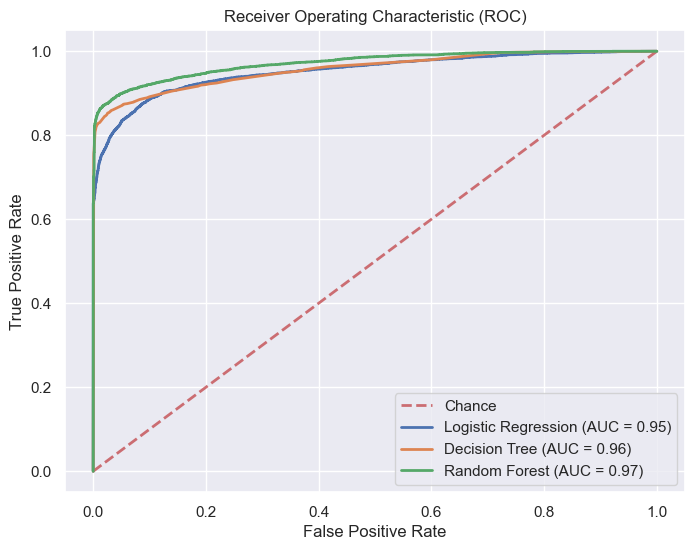

In [360]:
from sklearn.metrics import accuracy_score, roc_curve, auc

# --- Plot ROC Curves ---
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

# Logistic Regression ROC Curve
y_pred_proba_lr = final_model_lr.predict_proba(X_test)[:, 1]
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_pred_proba_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.plot(fpr_lr, tpr_lr, lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')

# Decision Tree ROC Curve
y_pred_proba_dt = final_model_dt.predict_proba(X_test)[:, 1]
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_pred_proba_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)
plt.plot(fpr_dt, tpr_dt, lw=2, label=f'Decision Tree (AUC = {roc_auc_dt:.2f})')

# Random Forest ROC Curve
y_pred_proba_rf = final_model_rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_proba_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

**แกนของกราฟ:**
* แกน x (False Positive Rate - FPR): สัดส่วนของลูกค้าที่ ไม่ผิดนัด แต่โมเดลทำนาย ผิด ว่าผิดนัด
* แกน y (True Positive Rate - TPR): สัดส่วนของลูกค้าที่ ผิดนัด และโมเดลทำนาย ถูก

**เส้นบนกราฟ:**
* เส้นทแยงมุม (Chance): โมเดลสุ่ม ทำนายถูก 50% ผิด 50% มี AUC = 0.5
* เส้นของแต่ละโมเดล:
    * Logistic Regression: เส้นสีน้ำเงิน
    * Decision Tree : เส้นสีส้ม
    * Random Forest : เส้นสีเขียว
    
**การแปลผล:**
* AUC (Area Under the Curve): พื้นที่ใต้เส้น ROC curve เป็น metric ที่ใช้วัดประสิทธิภาพของโมเดล ยิ่งค่า AUC สูง โมเดลยิ่งมีประสิทธิภาพในการแยกแยะ class
* โมเดลที่ดี: เส้น ROC curve ควรอยู่เหนือเส้น "Chance" ให้มากที่สุด และมีค่า AUC ใกล้เคียง 1

**สรุปจากกราฟ:**
* ทั้งสามโมเดลมีประสิทธิภาพที่ดี โดย Random Forest มีค่า AUC สูงสุด (0.97) ตามด้วย Decision Tree (0.96) และ Logistic Regression (0.95)
* Random Forest เป็นโมเดลที่ดีที่สุดในสามโมเดล ตามด้วย Decision Tree และ Logistic Regression 

* **AUC: เป็น metric ที่ใช้วัดประสิทธิภาพโดยรวมของโมเดล โดยไม่ขึ้นอยู่กับ threshold**
* **AUC สูง บ่งบอกว่าโมเดลแยกแยะผู้กู้ที่ดีและผู้กู้ที่มีความเสี่ยงได้ดี**
* **AUC ไม่ได้บอกโดยตรงว่าควรปล่อยกู้หรือไม่ ต้องดู Precision หรือ Recall ประกอบ**

## 6.3 เลือก Best Model

**ความหมายของ metrics  สำหรับ  Credit Scoring:**

* **Accuracy:**  
    * แม่นยำแค่ไหนในการทำนายทั้งหมด (ทั้งคนที่ผิดนัดและไม่ผิดนัด)
* **Precision:**  
    * แม่นยำแค่ไหนในการทำนายว่า **คนจะผิดนัด** (ไม่ปล่อยกู้ให้คนผิดนัด)
* **Recall:**  
    * ครอบคลุมแค่ไหนในการจับ **คนจะผิดนัด**
* **F1-score:**  
    * ความสมดุลระหว่าง Precision และ Recall (เก่งทั้งจับคนผิดนัด และไม่พลาดคนไม่ผิดนัด)
* **AUC:**  
    * วัดความสามารถในการแยก **คนผิดนัด กับ คนไม่ผิดนัด** โดยรวม (ไม่สนใจว่าจะปล่อยกู้หรือไม่)

In [361]:
# แสดงผลลัพธ์ metrics  --- Logistic Regression ---
print("----- Logistic Regression -----")
print(f"Accuracy (Test Set): {test_accuracy_lr:.4f}")
print(f"Precision (Test Set): {test_precision_lr:.4f}")
print(f"Recall (Test Set): {test_recall_lr:.4f}")
print(f"F1-score (Test Set): {test_f1_lr:.4f}\n")

# แสดงผลลัพธ์ metrics   --- Decision Tree ---
print("----- Decision Tree -----")
print(f"Accuracy (Test Set): {test_accuracy_dt:.4f}")
print(f"Precision (Test Set): {test_precision_dt:.4f}")
print(f"Recall (Test Set): {test_recall_dt:.4f}")
print(f"F1-score (Test Set): {test_f1_dt:.4f}\n")

# แสดงผลลัพธ์ metrics   --- Random Forest ---
print("----- Random Forest -----")
print(f"Accuracy (Test Set): {test_accuracy_rf:.4f}")
print(f"Precision (Test Set): {test_precision_rf:.4f}")
print(f"Recall (Test Set): {test_recall_rf:.4f}")
print(f"F1-score (Test Set): {test_f1_rf:.4f}\n")

----- Logistic Regression -----
Accuracy (Test Set): 0.8953
Precision (Test Set): 0.9215
Recall (Test Set): 0.8444
F1-score (Test Set): 0.8812

----- Decision Tree -----
Accuracy (Test Set): 0.9184
Precision (Test Set): 0.9660
Recall (Test Set): 0.8527
F1-score (Test Set): 0.9058

----- Random Forest -----
Accuracy (Test Set): 0.9304
Precision (Test Set): 0.9782
Recall (Test Set): 0.8681
F1-score (Test Set): 0.9199



**เมื่อสถาบันการเงิน มี 2 เป้าหมายหลัก คือ**

1. ลดความเสี่ยง: ไม่อยากปล่อยกู้ให้กับ **ผู้ที่ผิดนัดชำระหนี้**
2. เพิ่มผลกำไร: อยากปล่อยกู้ให้กับ **ผู้ที่ไม่ผิดนัดชำระหนี้** มากที่สุด

**ดังนั้น Metric ที่ควรเน้น คือ**
* เน้นลดความเสี่ยง: **Recall**
    * Recall สูง หมายถึง โมเดลสามารถจับผู้ที่ผิดนัดชำระหนี้ได้ครอบคลุม
* เน้นเพิ่มผลกำไร: **Precision**
    * Precision สูง หมายถึง โมเดลแม่นยำในการระบุผู้ที่ผิดนัดชำระหนี้

💖เมื่อพิจารณาจาก metrics  Recall และ Precision สูงที่สุด 
จะได้ Best Model คือ **Random Forest Classifier**

# 7. การดึงโมเดล ออกไปใช้งาน

## 7.1 การบันทึกโมเดล Random Forest Classifier

In [362]:
# บันทึกโมเดลที่ดีที่สุดด้วย pickle  
#โมเดลชื่อว่า final_model_rf

import pickle
filename ='Credit_Scoring_Model.pkl'
pickle.dump(final_model_rf, open(filename, 'wb'))

## 7.2  การโหลดโมเดลกลับมาใช้

## 7.3 วิธีทำนายความน่าจะเป็นของการอนุมัติหรือปฏิเสธให้กับผู้สมัครขอสินเชื่อ

#### ทำนายค่า
- Credit_Scoring_Model = Credit_Scoring_Model.predict(new_data)
- โดย new_data ต้องผ่านการทำ Data processing มาแล้ว

#### แสดงผลลัพธ์
- print("Predictions:", Credit_Scoring_Model)

**💛💛---------------------------------------------------------------------------------------------------------------------------------------------💛💛**